**Goal of this notebook: import history of the US yield curve and major economic data from the St. Louis Fed. Partition the data into four subsets and reduce the number of variables via PCA. Build a vector error correction model to predict future levels of the principal components, then use inverse transforms to recover predictions for each variable in the original series. See if we learn anything enlightening, or walk away more confused than when we started.**


Cell below imports fredapi to access the data.

In [1]:
pip install fredapi

Library imports. Nothing to see here.

In [2]:
from fredapi import Fred
import math
from datetime import timedelta
import itertools
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn import linear_model
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection  import train_test_split
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from dateutil.relativedelta import relativedelta


Some functions we will need to sync up weekly data with monthly data. St. Louis Fed indexes weekly economic data by the current month but monthly data by the prior month. Also, a nice function for calculating regressions and spitting out charts.

In [48]:
def calc_and_show_regression(seriesx, seriesy):  #clean regression of two series

  x_clean = pd.DataFrame(seriesx.dropna())
  y_clean = seriesy.dropna()

  x_vals = x_clean.loc[x_clean.index.intersection(y_clean.index)].values
  y_vals = y_clean.loc[x_clean.index.intersection(y_clean.index)].values

  x_vals = x_vals.reshape(-1, len(x_clean.columns))


  y_vals = y_vals.reshape(-1, 1)


  model = linear_model.LinearRegression()
  model.fit(x_vals, y_vals)

  pred_vals = model.predict(x_vals)
  resid = y_vals - pred_vals
  print("Target variable: ", y_clean.name, "\n")
  print("Regressors: ", " ".join(x_clean.columns.tolist()), "\n")
  print("Coefficients: ", dict(zip(x_clean.columns, model.coef_[0].tolist())), "\n")
  print("R2: ", str(r2_score(y_vals, pred_vals)), "\n")
  print("Residuals pass mean reversion test? ", adfuller(resid)[1]<0.05, "\n")

  if x_vals.shape[1]==1:
    fig, ax = plt.subplots()
    plt.scatter(x_vals, y_vals)

    plt.plot(y_vals, pred_vals)
    plt.xlabel(y_clean.name)
    plt.ylabel("Pred val")
    ax.set_title('R2: ' + str(r2_score(y_vals, pred_vals)))
    plt.title("Actual values of "+y_clean.name+" against values predicted by "+x_clean.columns[0])
    plt.show()
    plt.clf()
  else:
    fig, ax = plt.subplots()

    plt.scatter(y_vals, pred_vals)
    plt.xlabel(y_clean.name)
    plt.ylabel("Pred val")
    ax.set_title('R2: ' + str(r2_score(y_vals, pred_vals)))
    plt.title("Actual values of "+y_clean.name+" against values predicted by "+" ".join(x_clean.columns.tolist()))
    plt.show()
    plt.clf()

  plt.clf()
  plt.plot(x_clean.index.intersection(y_clean.index), resid)
  plt.title("Residuals over time")
  plt.xlabel("Date")
  plt.ylabel("Residual")
  plt.show()
  plt.clf()

def shift_date_backward(date):               #shift date 1 month backward. Need this to sync up monthly rates data to monthly econ data releases
  if date.month>1:
    return date.replace(month=(date.month-1))
  else:
    return date.replace(month=12).replace(year = date.year-1)

def get_monthly_date(date):
  return shift_date_backward(date.replace(day=1))  #sync up a weekly series to the monthly release dates

Data imports happen here. For weekly series, take average value over the month and shift the month backward by one. For example, for all continued claims releases in January 2025, take the average value and assign to index 12/01/2024 (since monthly series released in January 2025 will have 12/01/2024 as their index).  

In [4]:
rates_key_to_title = {"DFF": "Fed funds rate", "MORTGAGE30US": "30y mortgage rate", "DGS1": "1y rate", "DGS2": "2y rate", "DGS3": "3y rate",
                      "DGS5": "5y rate", "DGS10": "10y rate", "DGS30": "30y rate"}                                               #US Treasury yield curve + 30y mortgage rate + Fed funds

monthly_key_to_title = {"HOUST": "Housing starts", "CPIHOSSL": "Housing CPI", "CPIENGSL": "Energy CPI", "CPIUFDSL": "Food CPI",   #monthly data releases
                "HSN1F": "New houses sold", "CPIAUCNS": "CPI","CRESTKCPIXSLTRM159SFRBATL": "CPI excluding food, energy, and shelter",
                "PPIFIS": "PPI", "PCEPI": "PCE", "PCEPILFE": "PCE excluding food and energy", "PAYEMS": "Payroll",
                "UNRATE": "Unemployment rate", "MICH": "Umich inflation", "CSUSHPINSA": "S&P national home price index",
                "AWHAETP": "Average weekly hours worked", "CIVPART": "Labor force participation rate",
                "JTSJOL": "Job openings", "CES0500000003": "Average hourly earnings"}

weekly_key_to_title = {"ICSA": "Initial claims", "CCSA": "Continued claims"}      #weekly data releases

weekly_rates_df = pd.DataFrame()  #import rates data. These series come weekly
for key, value in rates_key_to_title.items():
  weekly_rates_df[value] = fred.get_series(key, observation_start='1/01/1990', sort_order='asc')
monthly_rates_df = weekly_rates_df.groupby(weekly_rates_df.index.map(get_monthly_date)).mean()     #aggregate weekly rates data to monthly and shift backward to line up with econ data releases


econ_df = pd.DataFrame()

for key, value in monthly_key_to_title.items():   #monthly econ data series are easy to import
  econ_df[value] = fred.get_series(key, observation_start='1/01/1990', sort_order='asc')

for key, value in weekly_key_to_title.items():    #weekly econ data series require averaging and shifting backward 1 month
  weekly_series = fred.get_series(key, observation_start='1/01/1990', sort_order='asc')
  econ_df[value] = weekly_series.groupby(weekly_series.index.map(get_monthly_date)).mean()

total_df = pd.merge(econ_df, monthly_rates_df[monthly_rates_df.index.isin(econ_df.index)], left_index=True, right_index=True) #put everything together

Summarize our data

In [5]:
total_df.describe()

Housing starts  Housing CPI  Energy CPI    Food CPI  New houses sold  \
count      421.000000   421.000000  421.000000  421.000000       421.000000   
mean      1324.876485   208.721620  178.674230  208.903829       698.090261   
std        382.294251    54.154147   62.184999   54.429077       243.953043   
min        478.000000   126.100000   96.700000  129.700000       270.000000   
25%       1092.000000   161.500000  111.200000  162.000000       524.000000   
50%       1355.000000   209.743000  191.966000  203.232000       666.000000   
75%       1570.000000   242.071000  226.022000  247.856000       864.000000   
max       2273.000000   340.995000  332.281000  335.671000      1389.000000   

              CPI  CPI excluding food, energy, and shelter         PPI  \
count  421.000000                               421.000000  183.000000   
mean   207.326952                                 2.547823  118.184393   
std     49.093634                                 1.163151   13.432913   
min    127.400000                                 0.832323  100.200000   
25%    163.900000                                 1.764132  109.300000   
50%    208.299000                                 2.247763  112.600000   
75%    239.261000                                 3.015699  123.450000   
max    317.671000                                 5.983499  147.975000   

              PCE  PCE excluding food and energy  ...  Initial claims  \
count  421.000000                     421.000000  ...    4.210000e+02   
mean    86.568154                      86.664043  ...    3.707517e+05   
std     17.152163                      16.382333  ...    2.790033e+05   
min     58.553000                      59.181000  ...    1.977500e+05   
25%     71.223000                      72.937000  ...    2.852000e+05   
50%     86.661000                      85.988000  ...    3.372500e+05   
75%     97.993000                      98.117000  ...    3.950000e+05   
max    125.175000                     124.334000  ...    4.663250e+06   

       Continued claims  Fed funds rate  30y mortgage rate     1y rate  \
count      4.210000e+02      421.000000         421.000000  421.000000   
mean       2.964238e+06        2.835226           5.993296    2.970339   
std        1.879784e+06        2.350041           1.852685    2.289114   
min        1.359250e+06        0.049000           2.684000    0.050500   
25%        2.180250e+06        0.200968           4.255000    0.543158   
50%        2.600000e+06        2.405161           6.147500    2.670455   
75%        3.296250e+06        5.235161           7.200000    5.010952   
max        2.032640e+07        8.288667          10.477500    8.404500   

          2y rate     3y rate     5y rate    10y rate    30y rate  
count  421.000000  421.000000  421.000000  421.000000  421.000000  
mean     3.218539    3.402381    3.747935    4.241494    4.759601  
std      2.284289    2.229567    2.124035    1.953715    1.795804  
min      0.115263    0.158095    0.266667    0.623636    1.265238  
25%      0.928947    1.316316    1.797500    2.570952    3.128000  
50%      3.107000    3.390000    3.707000    4.148500    4.644783  
75%      5.022000    5.105652    5.416000    5.738571    5.948182  
max      8.724000    8.782500    8.768000    8.893158    9.028947  

[8 rows x 28 columns]

Group data into [Rates, Employment, Housing, Prices]. We will need this grouping later. Then plot the values to see which series need to be differenced or log differenced.

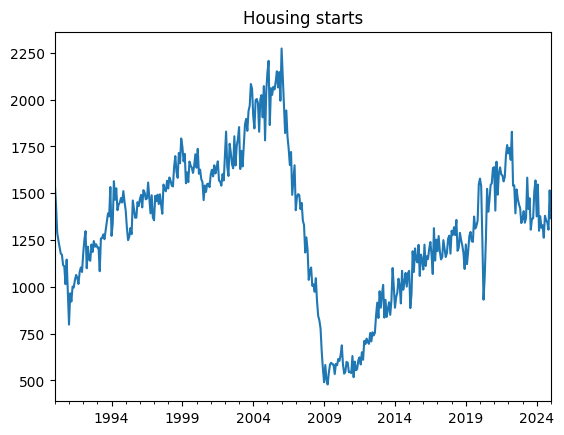

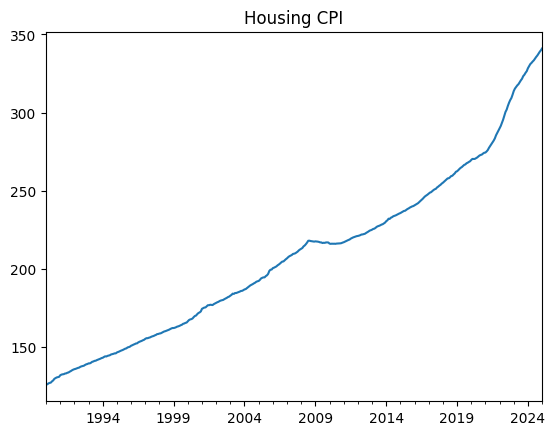

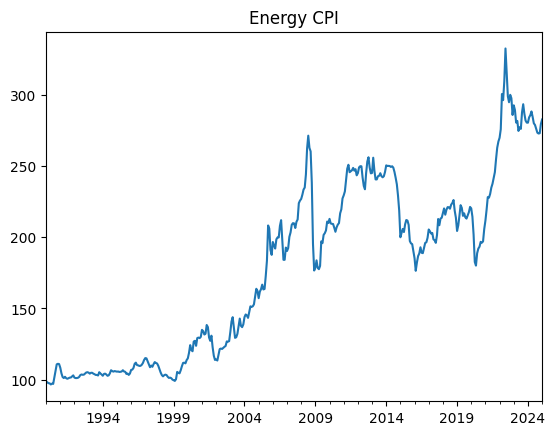

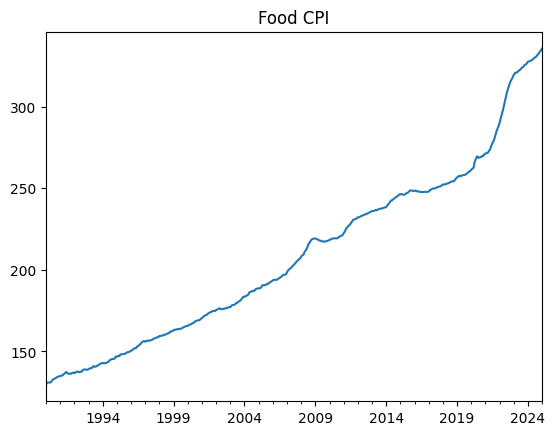

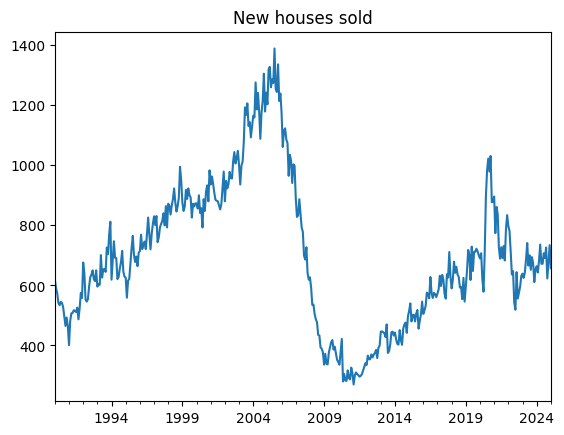

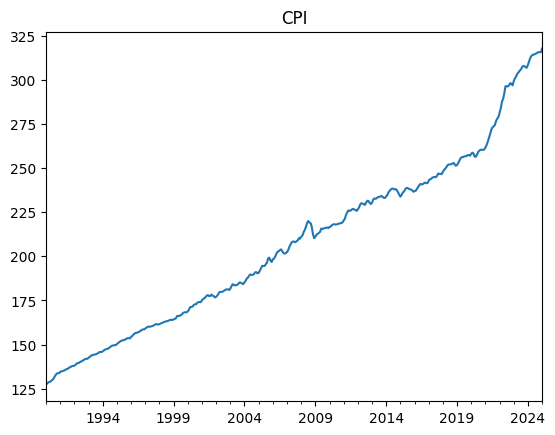

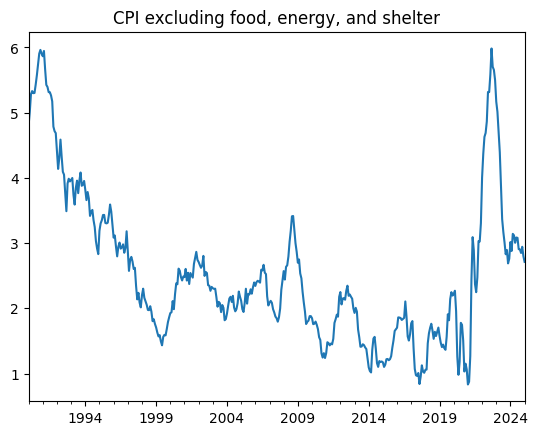

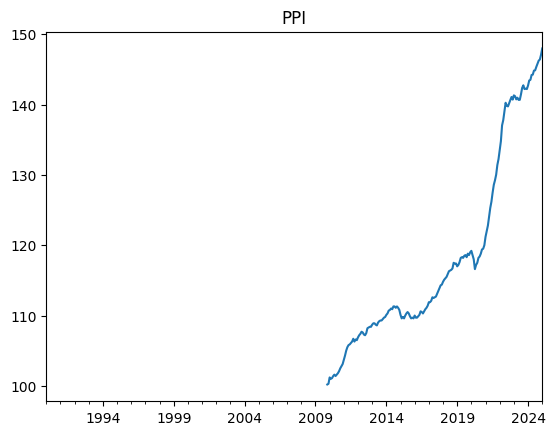

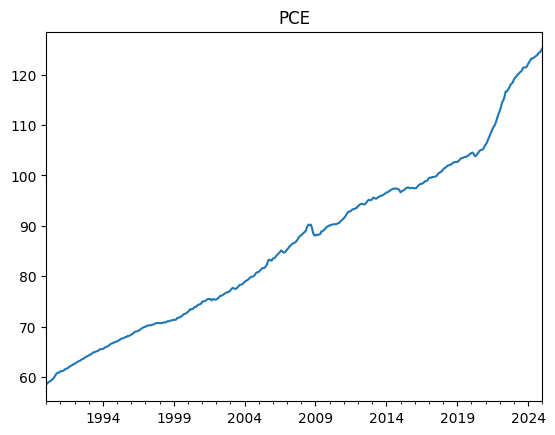

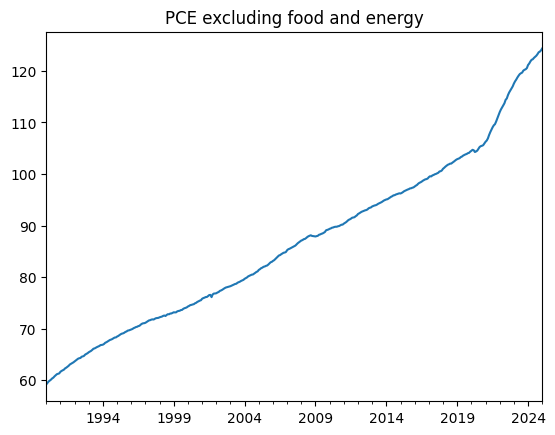

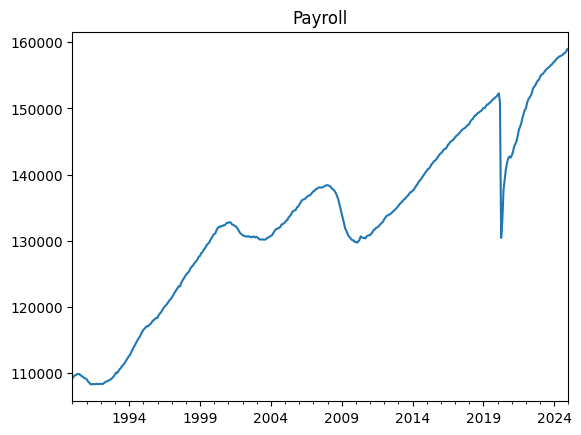

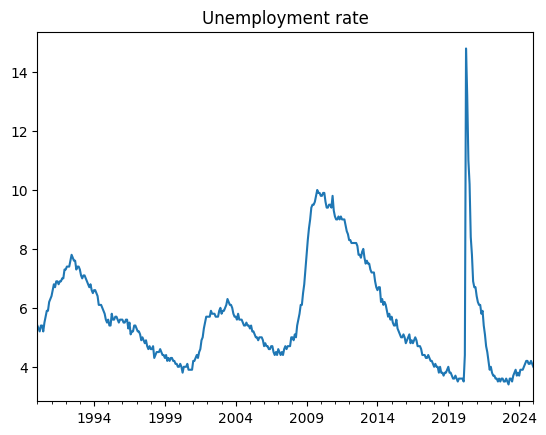

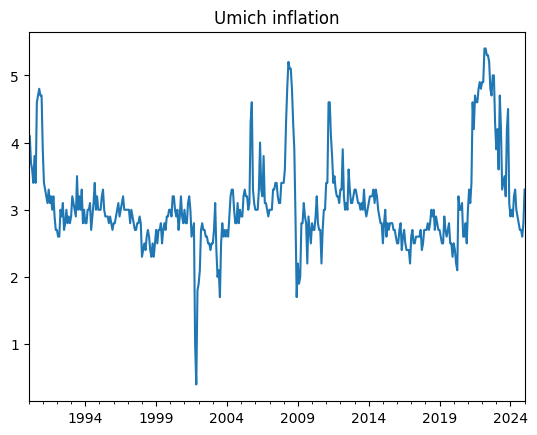

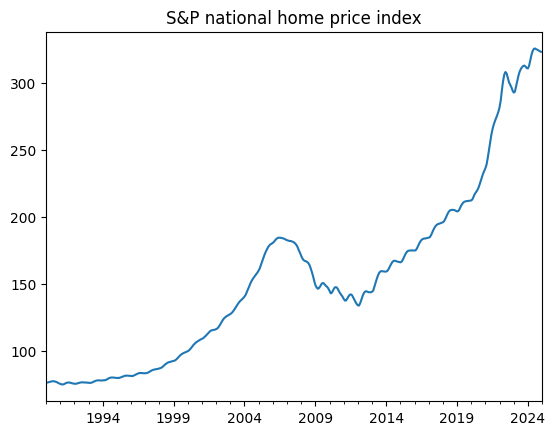

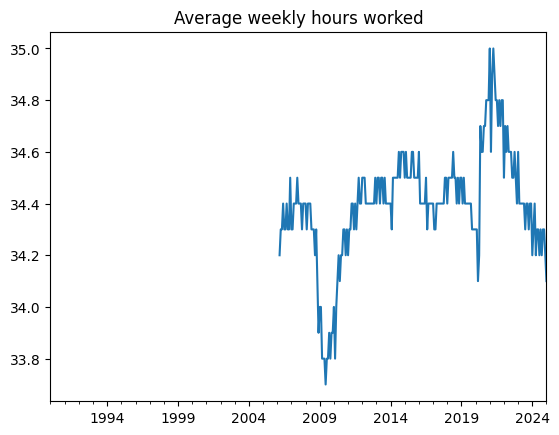

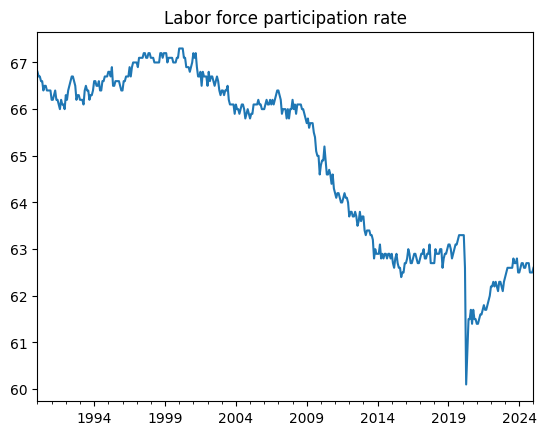

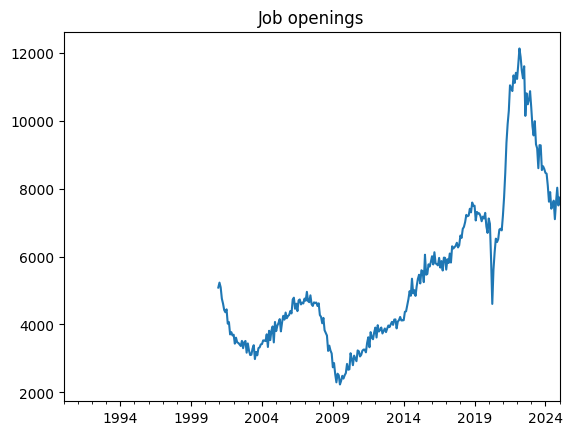

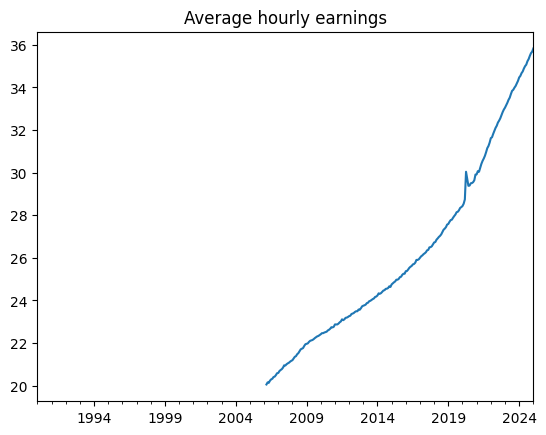

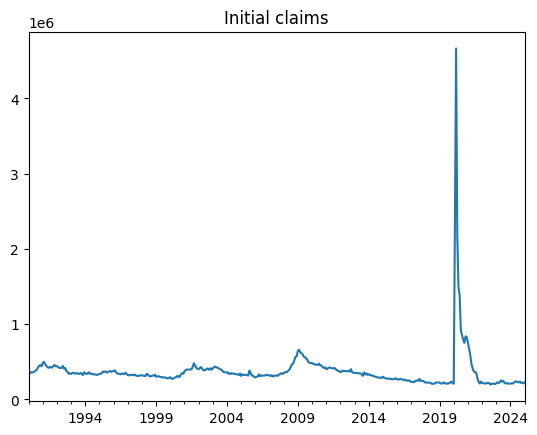

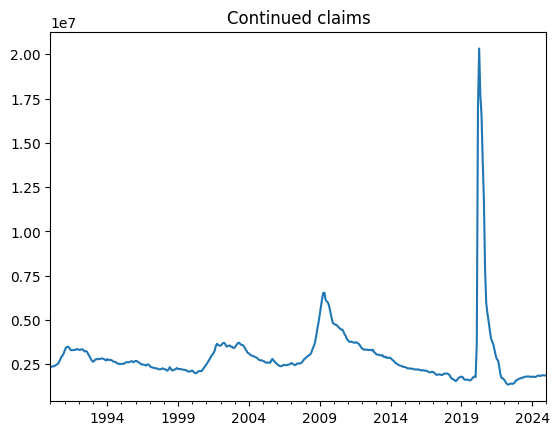

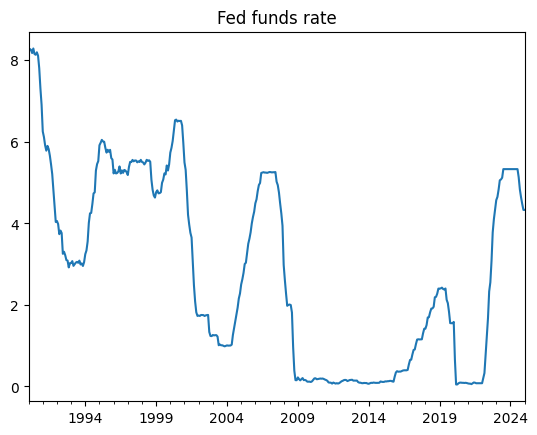

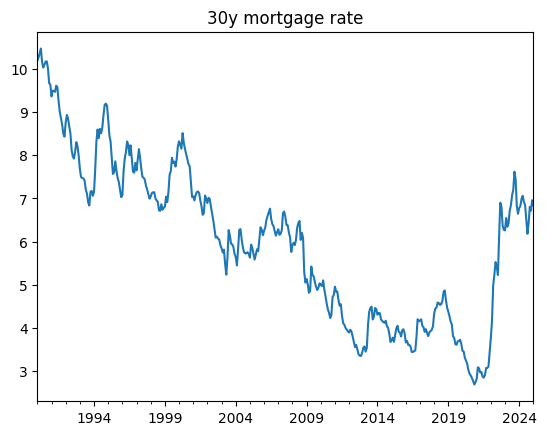

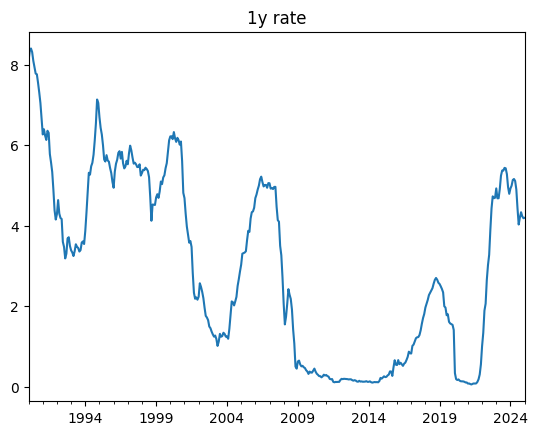

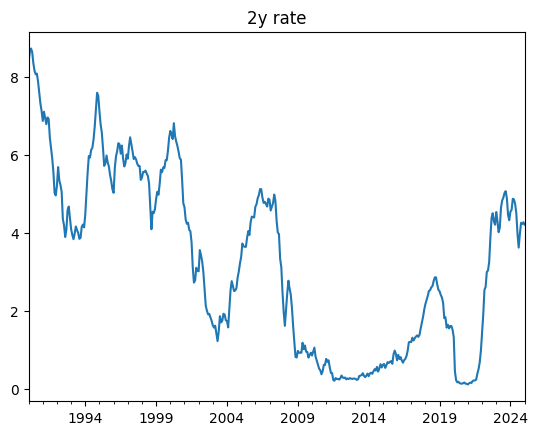

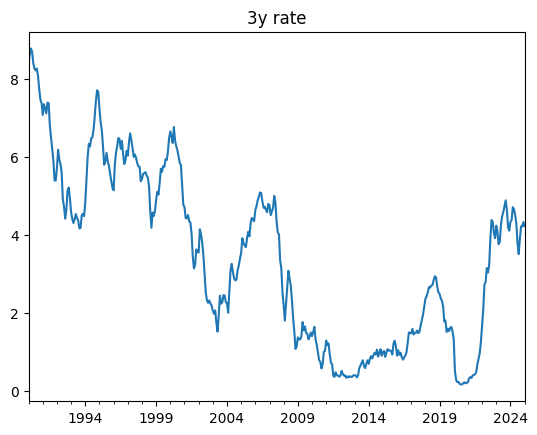

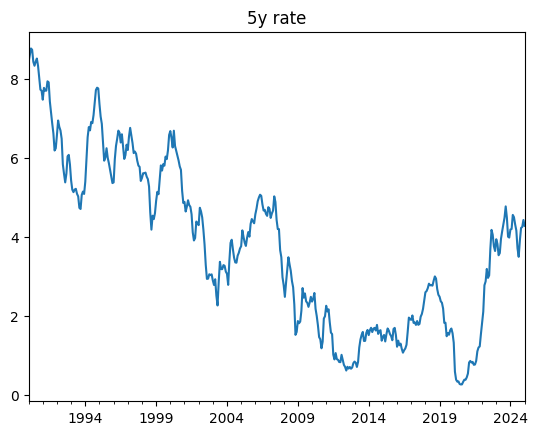

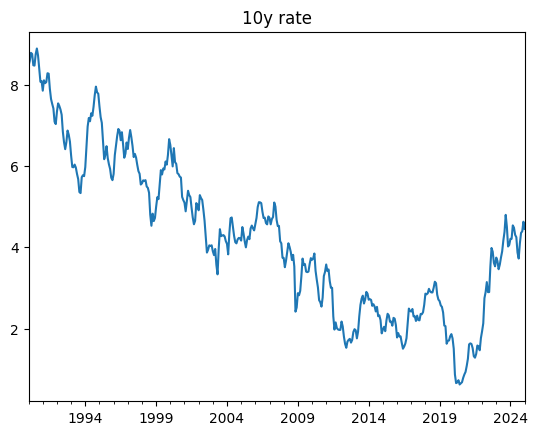

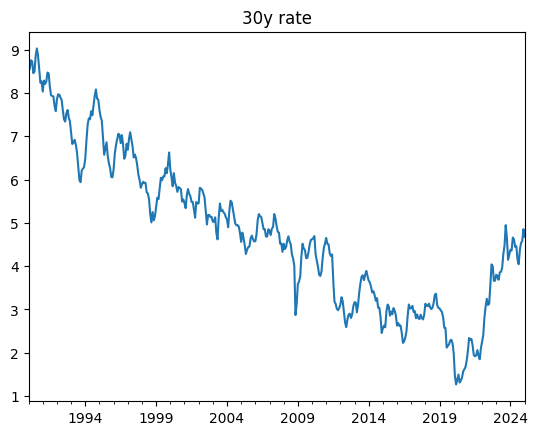

<Figure size 640x480 with 0 Axes>

In [6]:
employment_series = ["Payroll", "Unemployment rate", "Average weekly hours worked", "Labor force participation rate",
                     "Initial claims", "Continued claims", "Employment cost index", "Job openings", "Average hourly earnings"] #label series related to employment

prices_series = ["CPI", "CPI excluding food, energy, and shelter", "PPI", "PCE", "PCE excluding food and energy", "Umich inflation", "Housing CPI","Energy CPI", "Food CPI"]   #label series related to prices

housing_series = ["Housing starts", "S&P national home price index", "Housing CPI", "New houses sold"] #label series related to housing

rates_series = monthly_rates_df.columns #label series related to rates

series_to_group = {series: "Rates" if series in rates_series else "Employment" if series in employment_series else "Housing" if series in housing_series else "Prices" for series in total_df.columns} #map series to label

#plot every variable to get a better look
for series in total_df:
  total_df[series].plot()
  plt.title(series)
  plt.show()
  plt.clf()

Log difference trending indices and average hourly earnings. Take first difference of payroll numbers (without logs), since we usually measure it as an absolute change month to month. Leave all other series as levels

In [7]:
log_differenced_series = ["S&P national home price index", "PCE excluding food and energy", "PCE", "PPI", "CPI", "Food CPI", "Energy CPI", "Housing CPI", "Average hourly earnings"]
differenced_series = ["Payroll"]

for series in differenced_series:
  total_df[series] = total_df[series].diff(1)
for series in log_differenced_series:
  total_df[series] = 100*(total_df[series].apply(lambda x: math.log(x)).diff(1))

total_df[log_differenced_series+differenced_series].describe()

S&P national home price index  PCE excluding food and energy  \
count                     419.000000                     420.000000   
mean                        0.343839                       0.176755   
std                         0.713723                       0.124408   
min                        -2.286436                      -0.569854   
25%                        -0.062043                       0.103624   
50%                         0.346929                       0.161410   
75%                         0.821630                       0.231629   
max                         2.681065                       0.701702   

              PCE         PPI         CPI    Food CPI  Energy CPI  \
count  420.000000  182.000000  420.000000  420.000000  420.000000   
mean     0.180900    0.214217    0.217544    0.226407    0.249881   
std      0.198997    0.358390    0.338566    0.251609    2.757668   
min     -1.187151   -1.193535   -1.933869   -0.510764  -19.874963   
25%      0.082147    0.000000    0.033490    0.069897   -0.856500   
50%      0.174878    0.187359    0.202296    0.191205    0.205476   
75%      0.289780    0.366810    0.413249    0.347968    1.536417   
max      0.960448    1.656214    1.364259    1.417058   12.628449   

       Housing CPI  Average hourly earnings       Payroll  
count   420.000000               226.000000    420.000000  
mean      0.236855                 0.256883    118.740476  
std       0.167085                 0.347780   1067.961740  
min      -0.320015                -1.150605 -20471.000000  
25%       0.142426                 0.129936     59.750000  
50%       0.221157                 0.239255    177.000000  
75%       0.308691                 0.365158    268.250000  
max       0.978989                 4.423995   4631.000000

Test order of integration for each series. Most are I(0) or
I(1), while a handful are I(2). Since we are using an error correction model, we will not apply logs or differences to nonstationary series to make them stationary.

In [8]:


#in this section, test order of integration for each series in dataset
non_stationary_series = []
for series in total_df.columns:
  if adfuller(total_df[series][total_df[series].notna()].values)[1]>0.01:
    non_stationary_series.append(series)



print("I(0) series in dataset: ", [series for series in total_df.columns if series not in non_stationary_series], "\n")
print("I(>0) series in dataset: ", non_stationary_series, "\n")


total_df_first_diff = total_df[total_df.notna()].diff(1).dropna()
order_one_series = []
for series in non_stationary_series:
  if adfuller(total_df_first_diff[series].values)[1]<0.01:
   order_one_series.append(series)

print("I(1) series in dataset: ", order_one_series, "\n")

total_df_second_diff = total_df[total_df.notna()].diff(1).diff(1).dropna()
order_two_series = []
for series in list(set(non_stationary_series)-set(order_one_series)):
  if adfuller(total_df_second_diff[series].values)[1]<0.01:
    order_two_series.append(series)

print("I(2) series in dataset: ", order_two_series, "\n")
print("I(>2) series in dataset: ", list(set(non_stationary_series)-set(order_one_series)-set(order_two_series)))


I(0) series in dataset:  ['Housing CPI', 'Energy CPI', 'Food CPI', 'CPI', 'PCE', 'Payroll', 'Umich inflation', 'Average hourly earnings', 'Initial claims', 'Continued claims'] 

I(>0) series in dataset:  ['Housing starts', 'New houses sold', 'CPI excluding food, energy, and shelter', 'PPI', 'PCE excluding food and energy', 'Unemployment rate', 'S&P national home price index', 'Average weekly hours worked', 'Labor force participation rate', 'Job openings', 'Fed funds rate', '30y mortgage rate', '1y rate', '2y rate', '3y rate', '5y rate', '10y rate', '30y rate'] 

I(1) series in dataset:  ['Housing starts', 'New houses sold', 'CPI excluding food, energy, and shelter', 'PPI', 'PCE excluding food and energy', 'Unemployment rate', 'Average weekly hours worked', 'Labor force participation rate', 'Job openings', '30y mortgage rate', '3y rate', '5y rate', '10y rate', '30y rate'] 

I(2) series in dataset:  ['S&P national home price index', '1y rate', 'Fed funds rate', '2y rate'] 

I(>2) series 

Reduce our dataset to rows without NA values. We are left with <200 data points, but 28 variables. Partition data into [Rates, Employment, Housing, Prices] and dimension reduce each group with PCA. For rates, we sepcify two PC factors (since we care about both outright level and curve). For the other three groups, we ask for enough factors to explain 80% of the variance. We are left with 9 latent variables.

<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]
<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]
<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

Employment explained var ratios: ,  [0.36065835 0.29986406 0.1821747 ] 

Series in Employment group:  ['Continued claims', 'Labor force participation rate', 'Average hourly earnings', 'Payroll', 'Initial claims', 'Job openings', 'Average weekly hours worked', 'Unemployment rate'] 



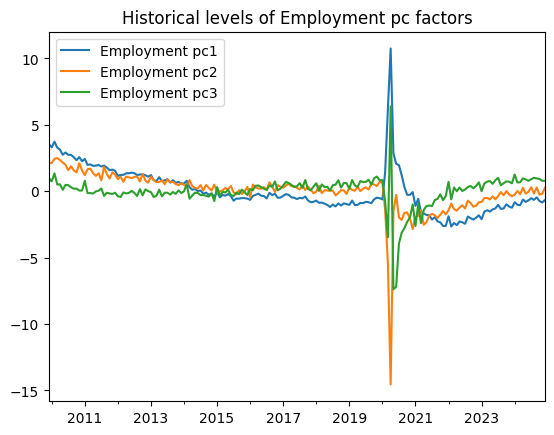

Prices explained var ratios: ,  [0.56110978 0.21122741] 

Series in Prices group:  ['PPI', 'Housing CPI', 'CPI', 'PCE excluding food and energy', 'PCE', 'Energy CPI', 'Food CPI', 'CPI excluding food, energy, and shelter', 'Umich inflation'] 



<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]
<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]


<Figure size 640x480 with 0 Axes>

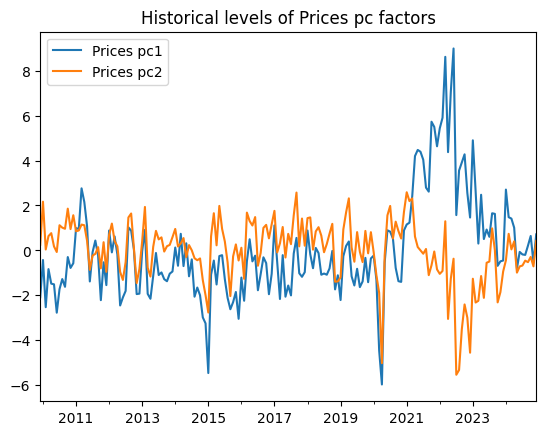

Housing explained var ratios: ,  [0.62559221 0.21140837] 

Series in Housing group:  ['S&P national home price index', 'Housing CPI', 'New houses sold', 'Housing starts'] 



<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]
<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]


<Figure size 640x480 with 0 Axes>

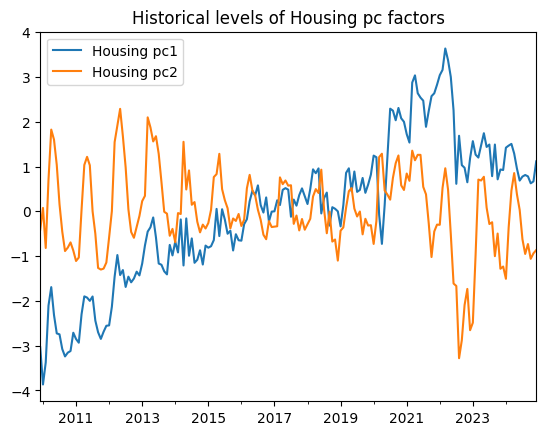

Rates explained var ratios: ,  [0.86172058 0.11904303] 

Series in Rates group:  ['30y rate', '5y rate', '3y rate', '1y rate', '2y rate', 'Fed funds rate', '10y rate', '30y mortgage rate'] 



<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]
<ipython-input-40-ab85ea148eda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]


<Figure size 640x480 with 0 Axes>

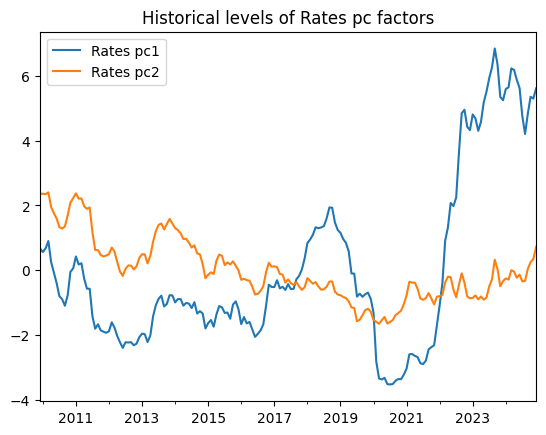

<Figure size 640x480 with 0 Axes>

In [40]:
total_df_long_hist = total_df.dropna(axis=0)
pca_object_dict = {}
pca_component_dict = {}
scaler_dict = {}

#run pca on levels in each of the econ data groups (employment, prices, housing, rates)
for title, group in {"Employment": employment_series, "Prices": prices_series, "Housing": housing_series, "Rates": rates_series}.items():

  applicable_cols = list(set(group)&set(total_df_long_hist.columns))
  this_group_series = total_df_long_hist[applicable_cols].copy()
  scaler = StandardScaler()


  this_group_series_stand = scaler.fit_transform(this_group_series)

  if title=="Rates":
    pca = PCA(n_components = 2)
  else:
    pca = PCA(n_components = 0.75, svd_solver="full")
  transformed_data = pca.fit_transform(this_group_series_stand)
  pca_component_dict[title] = pd.DataFrame(pca.components_,columns=this_group_series.columns,index = ["pc"+str(k+1) for k in range(len(pca.components_))])
  pca_object_dict[title] = pca
  scaler_dict[title] = scaler
  for k in range(len(pca.components_)):
    total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]


  print(title +" explained var ratios: , ", pca.explained_variance_ratio_, "\n")
  print("Series in "+title+" group: ", applicable_cols, "\n")
  total_df_long_hist[[series for series in total_df_long_hist if title+" pc" in series]].plot()
  plt.title("Historical levels of "+title+" pc factors")
  plt.show()
  plt.clf()



Now, we're curious how well the PCs explain each variable in the original space. We will look back on this later after making predictions, since poor prediction quality on a variable in the original space may be a sign that the dimension reduction crushes variance from that variable. In particular, notice how few employment series show mean reverting residuals when regressed against the PCA factors.





Target variable:  Housing starts 

Regressors:  Housing pc1 Housing pc2 

Coefficients:  {'Housing pc1': 194.10681965698993, 'Housing pc2': -46.878655289845504} 

R2:  0.9253162758840229 

Residuals pass mean reversion test?  True 



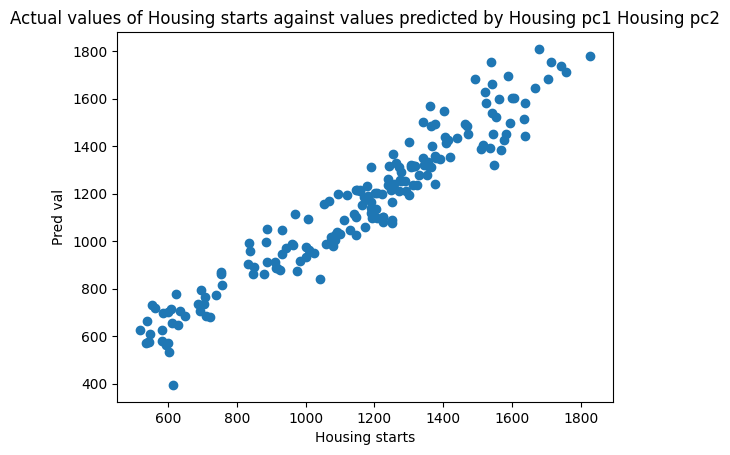

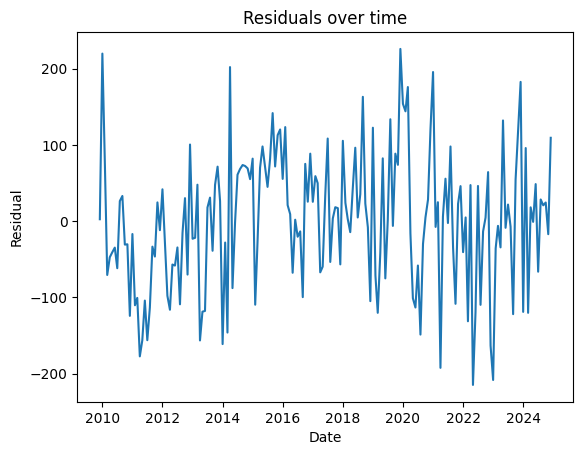





Target variable:  Housing CPI 

Regressors:  Housing pc1 Housing pc2 

Coefficients:  {'Housing pc1': 0.0790569306181496, 'Housing pc2': -0.08347434616380467} 

R2:  0.7057273644472757 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

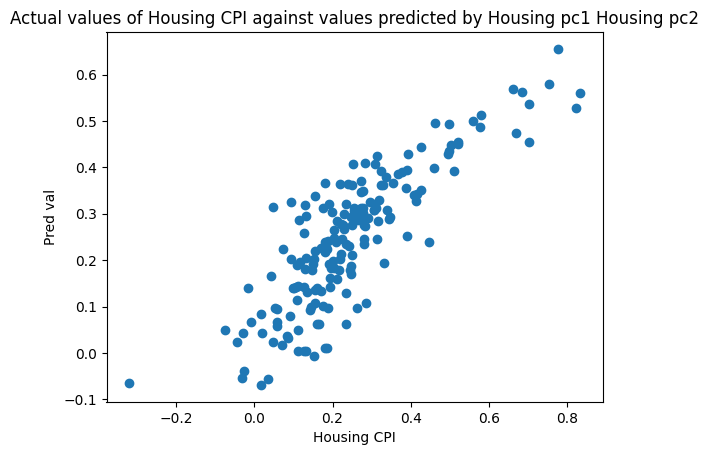

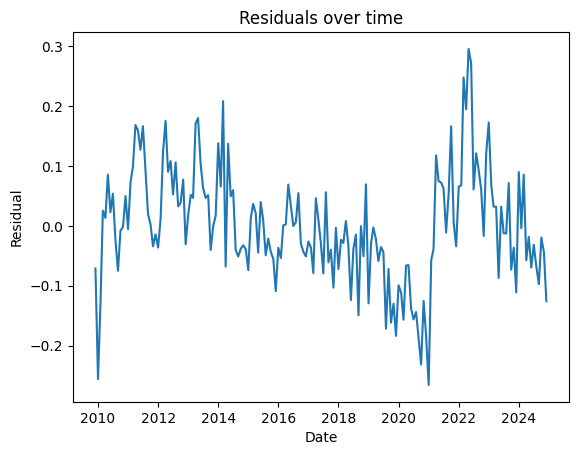





Target variable:  Energy CPI 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.6586901389947993, 'Prices pc2': 1.315396705978741} 

R2:  0.8718009805780269 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

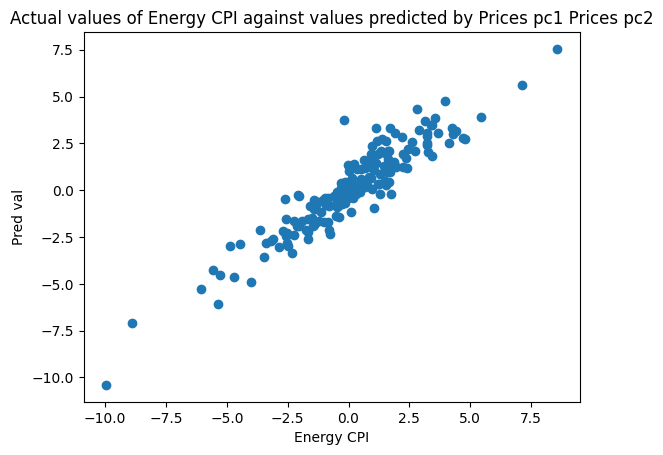

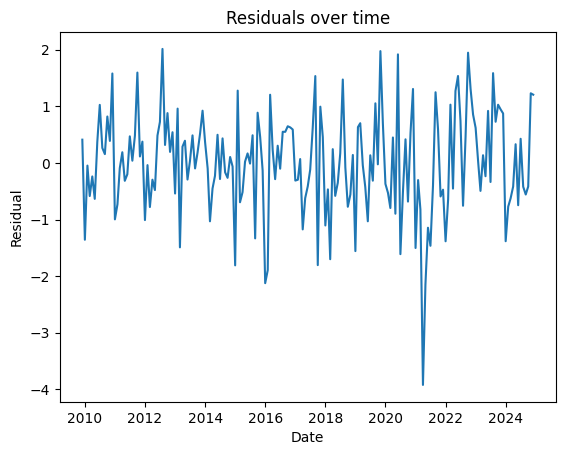





Target variable:  Food CPI 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.06972502482348665, 'Prices pc2': -0.09388954072125538} 

R2:  0.5762719367000031 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

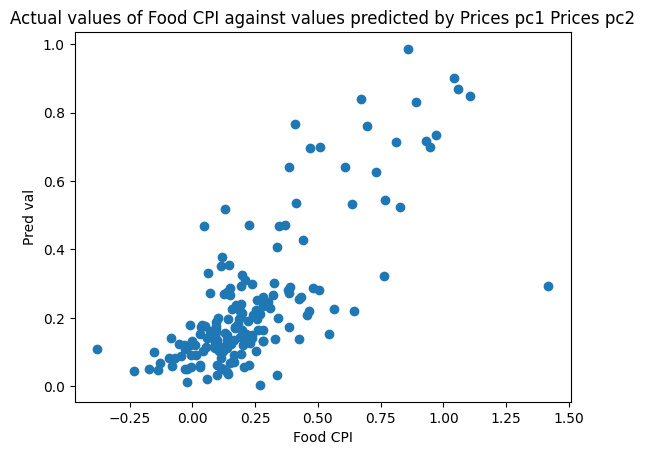

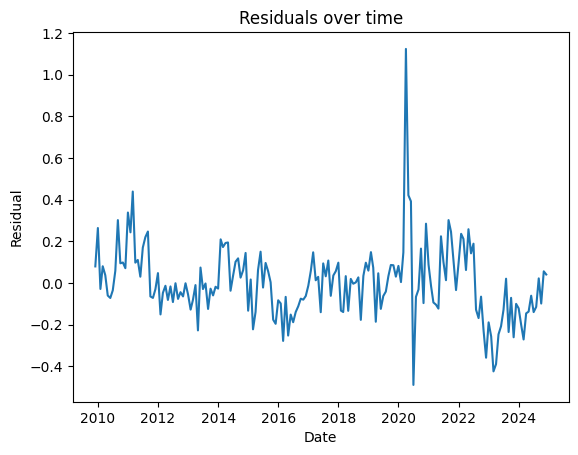





Target variable:  New houses sold 

Regressors:  Housing pc1 Housing pc2 

Coefficients:  {'Housing pc1': 93.62187040439397, 'Housing pc2': 2.807411745134174} 

R2:  0.7935388602872508 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

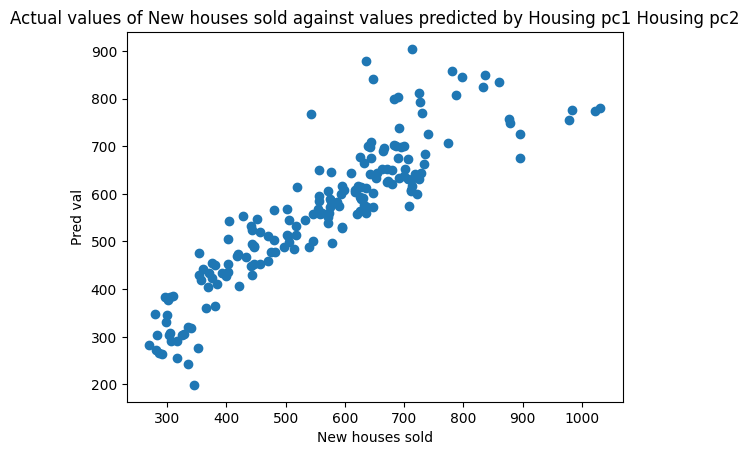

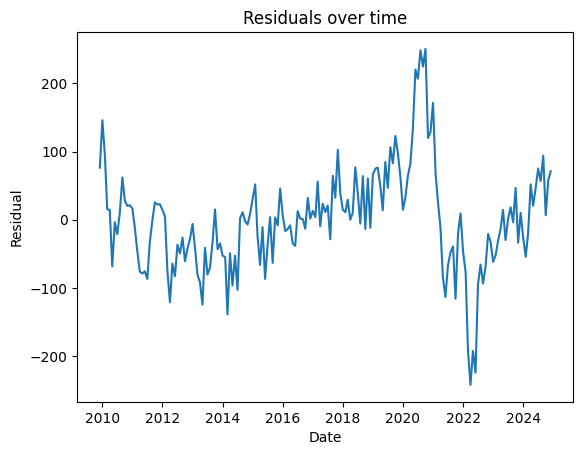





Target variable:  CPI 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.11790788822510563, 'Prices pc2': 0.09452631106686463} 

R2:  0.7592176309141765 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

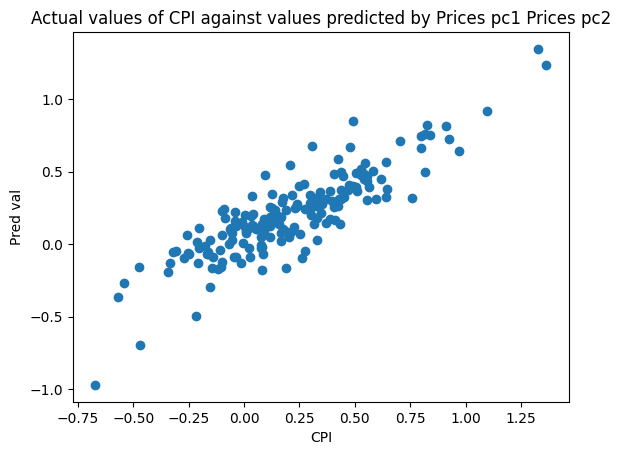

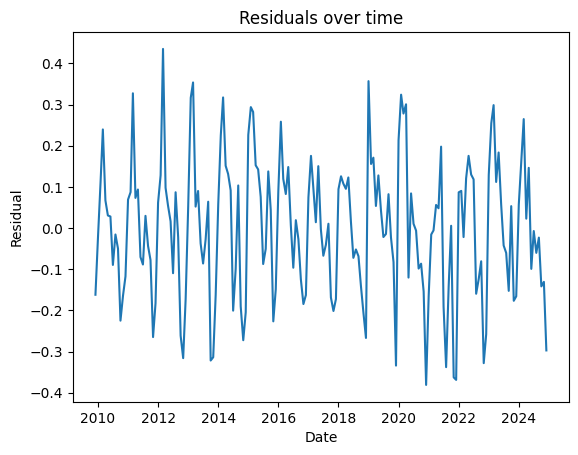





Target variable:  CPI excluding food, energy, and shelter 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.32481091633348086, 'Prices pc2': -0.4860691153943325} 

R2:  0.7809617158743375 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

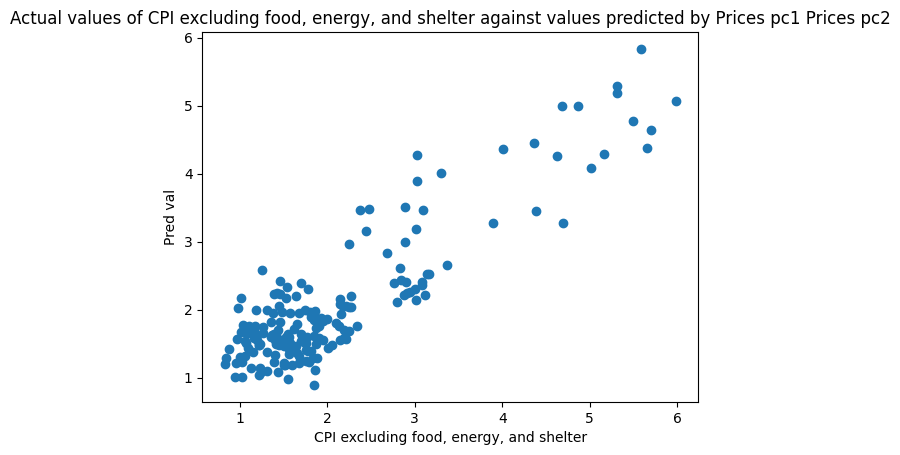

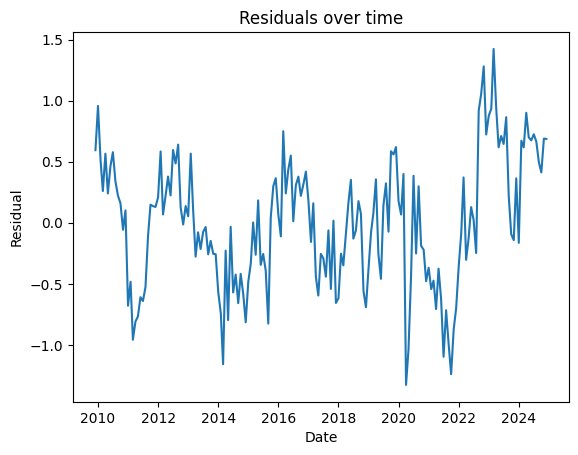





Target variable:  PPI 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.11771646072596946, 'Prices pc2': 0.1239325610126601} 

R2:  0.7773428113693689 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

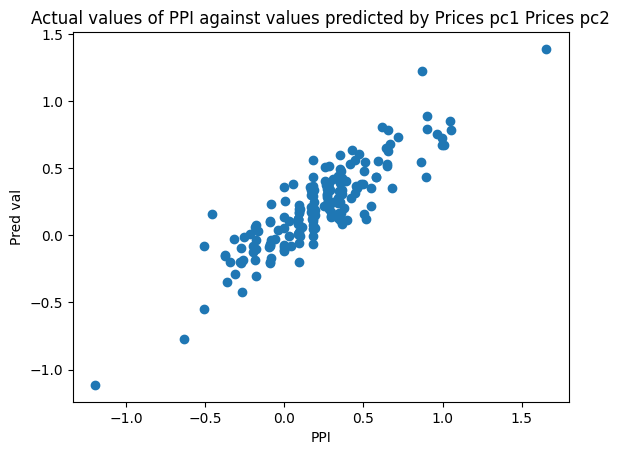

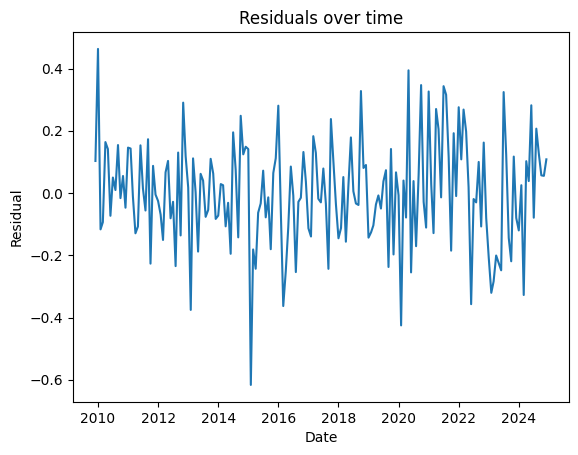





Target variable:  PCE 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.08063648754432425, 'Prices pc2': 0.04350904732192419} 

R2:  0.9544461306901185 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

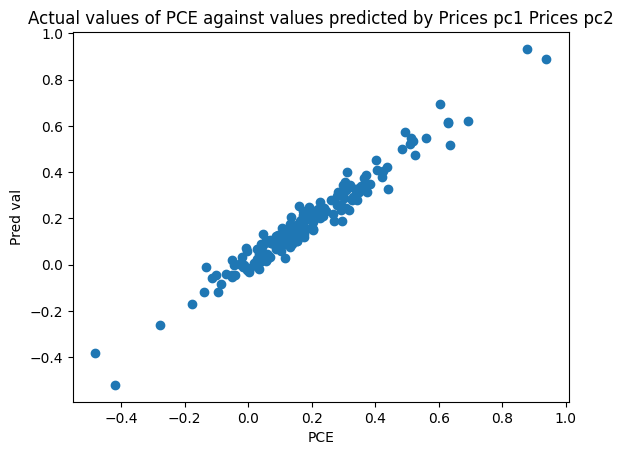

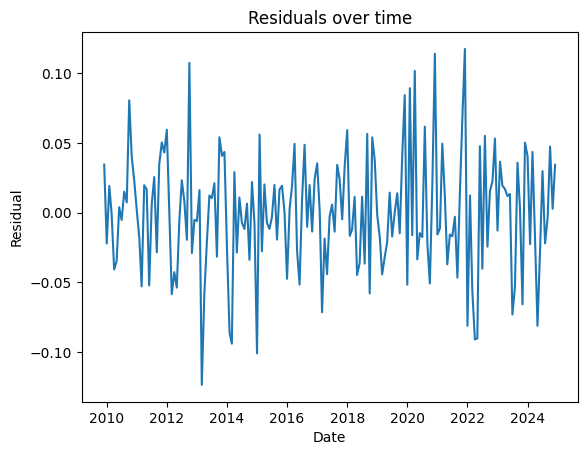





Target variable:  PCE excluding food and energy 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.05062936967882276, 'Prices pc2': -0.010681668146889839} 

R2:  0.7375085955763885 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

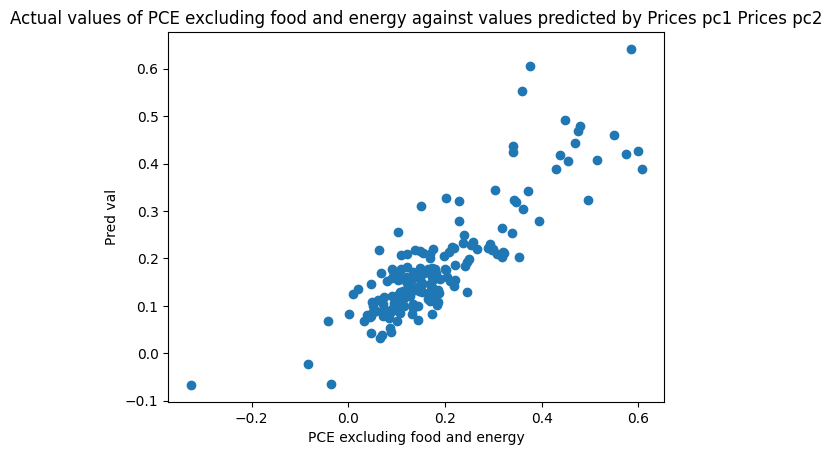

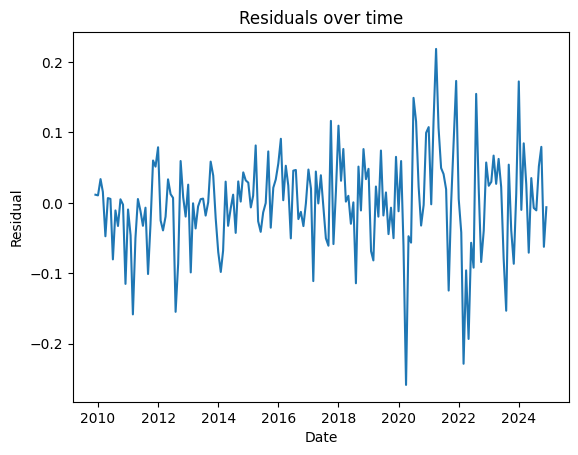





Target variable:  Payroll 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': -446.4150722579317, 'Employment pc2': 650.6413348761353, 'Employment pc3': -747.60990814458} 

R2:  0.936713107518229 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

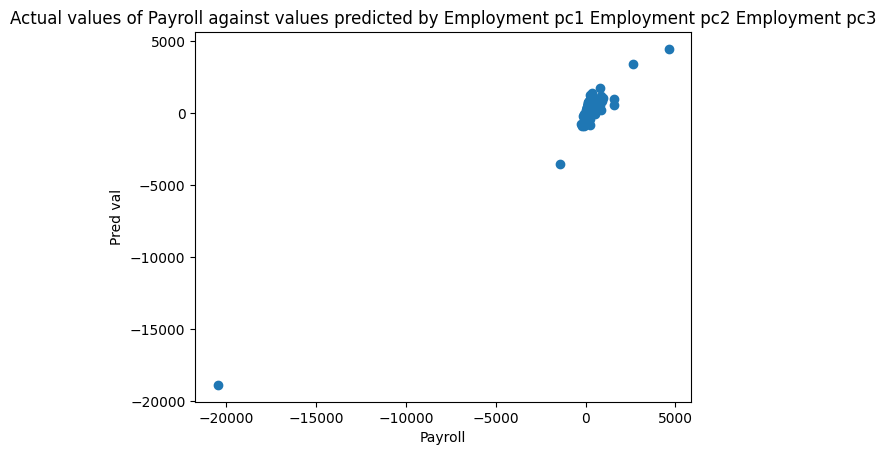

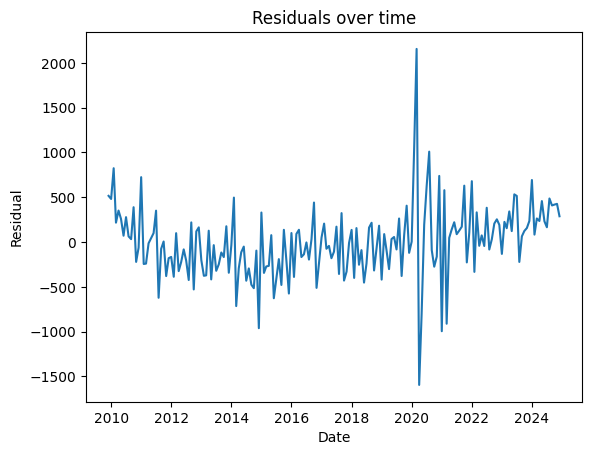





Target variable:  Unemployment rate 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': 1.1128329109043695, 'Employment pc2': 0.15695875639605406, 'Employment pc3': -0.49052728389399625} 

R2:  0.7901672384756472 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

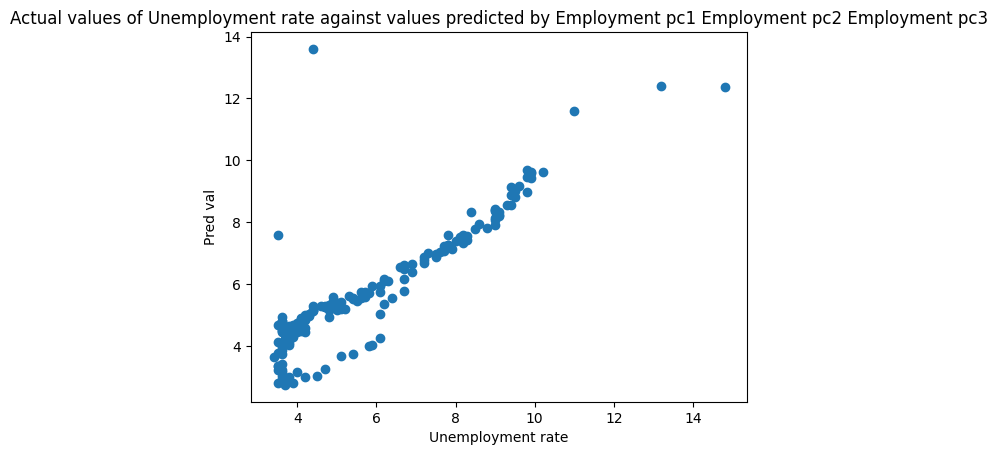

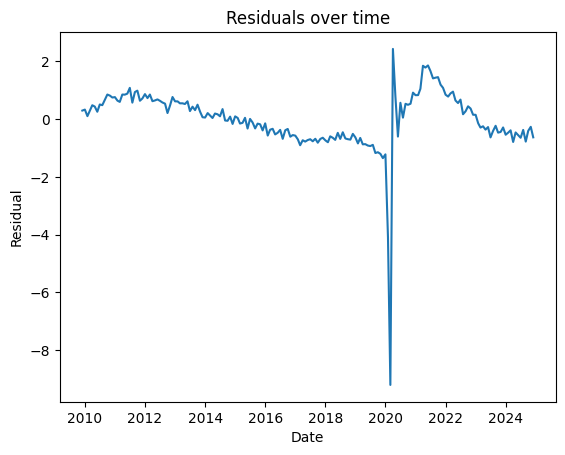





Target variable:  Umich inflation 

Regressors:  Prices pc1 Prices pc2 

Coefficients:  {'Prices pc1': 0.2619182210384822, 'Prices pc2': -0.2202177113441197} 

R2:  0.777449117881994 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

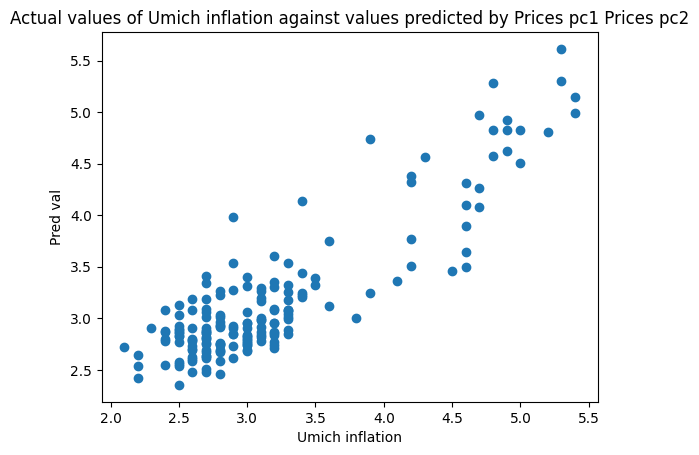

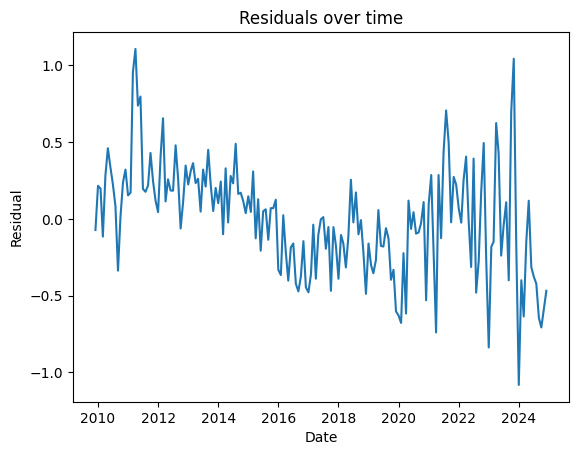





Target variable:  S&P national home price index 

Regressors:  Housing pc1 Housing pc2 

Coefficients:  {'Housing pc1': 0.2725576881358284, 'Housing pc2': 0.6946096232504684} 

R2:  0.9234198415681201 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

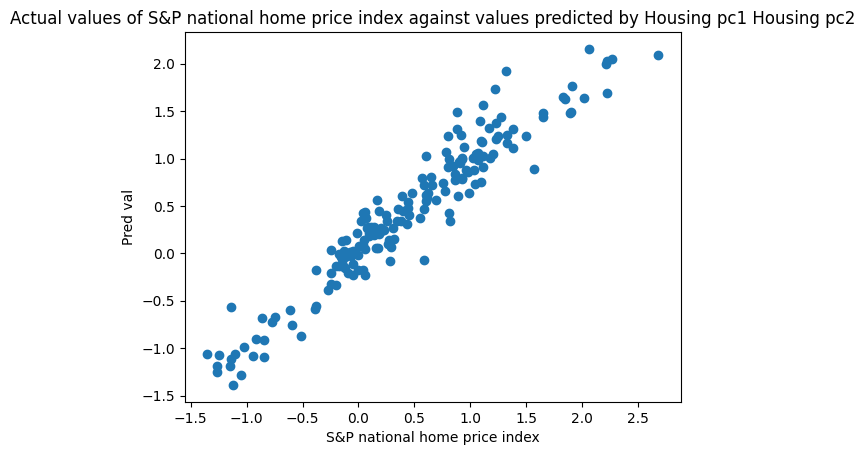

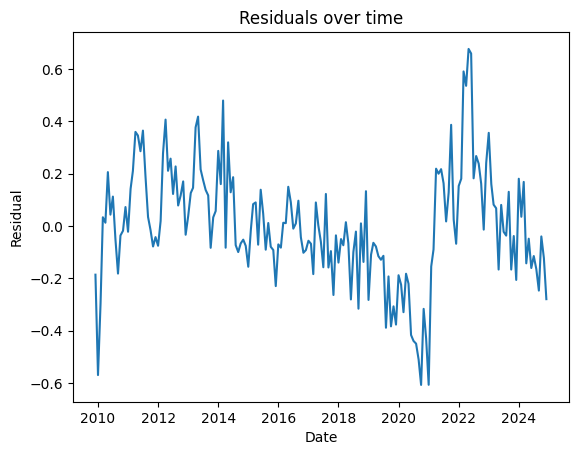





Target variable:  Average weekly hours worked 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': -0.05599699806731068, 'Employment pc2': -0.045732816560179496, 'Employment pc3': -0.07452526056888636} 

R2:  0.690893014938434 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

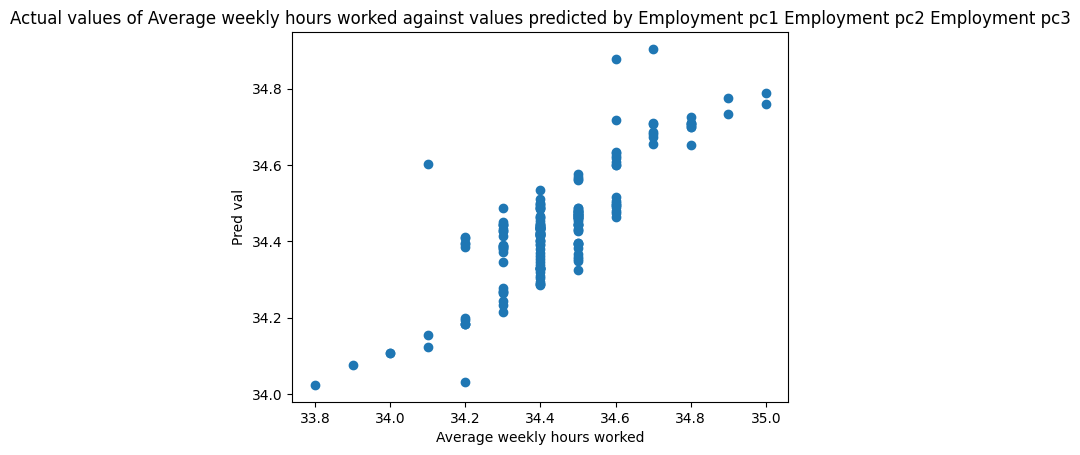

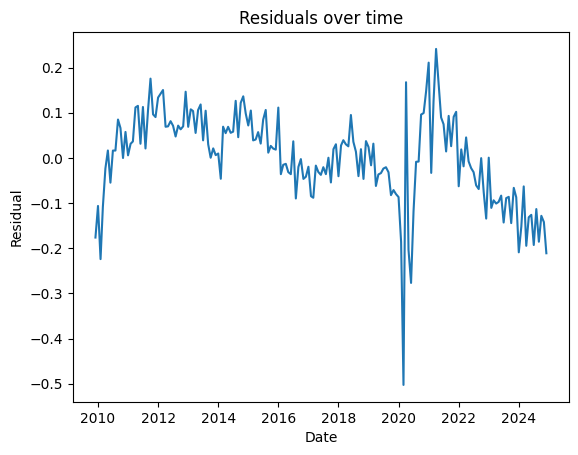





Target variable:  Labor force participation rate 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': 0.2311895378710669, 'Employment pc2': 0.4164855955684455, 'Employment pc3': 0.18906996447306806} 

R2:  0.9053102770287035 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

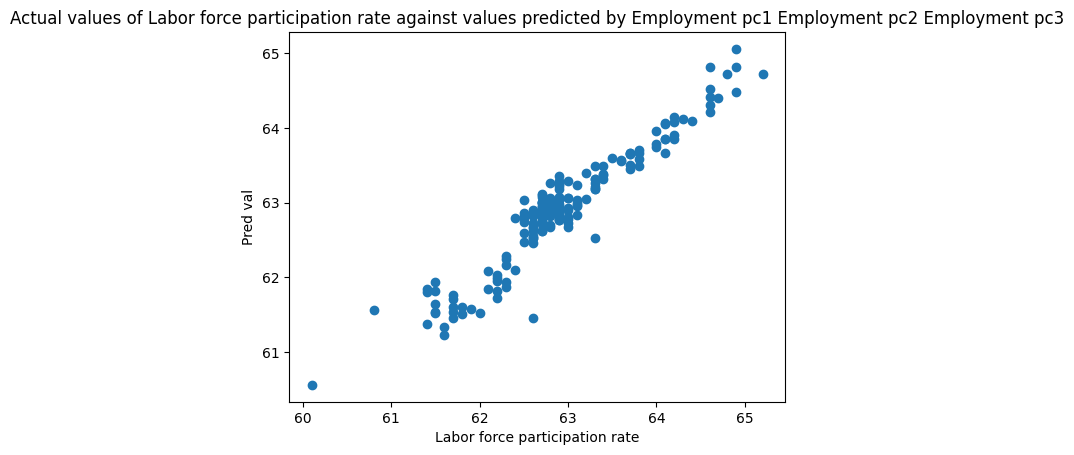

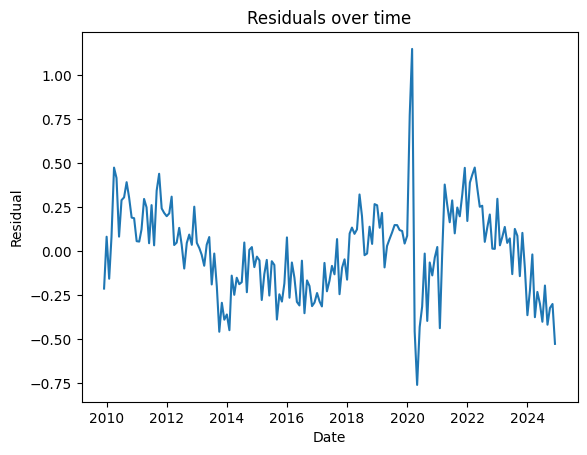





Target variable:  Job openings 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': -1102.576003731417, 'Employment pc2': -760.1188064840647, 'Employment pc3': 19.442365372887934} 

R2:  0.8375908122547981 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

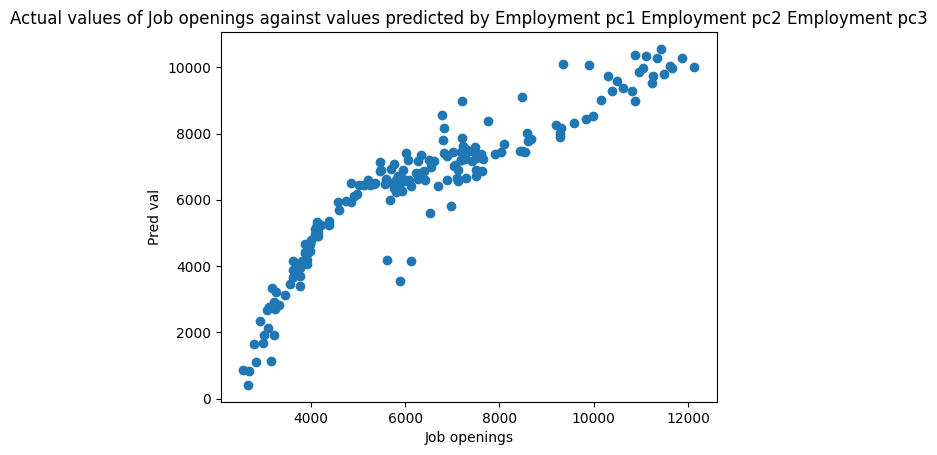

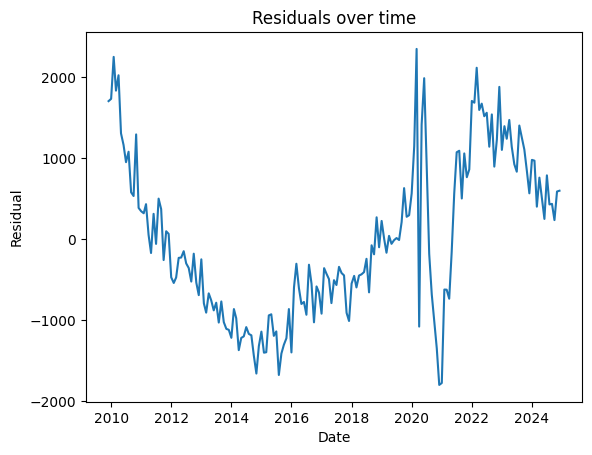





Target variable:  Average hourly earnings 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': 0.04577081789207156, 'Employment pc2': -0.18030585608193367, 'Employment pc3': 0.18834852388845447} 

R2:  0.9378315733214787 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

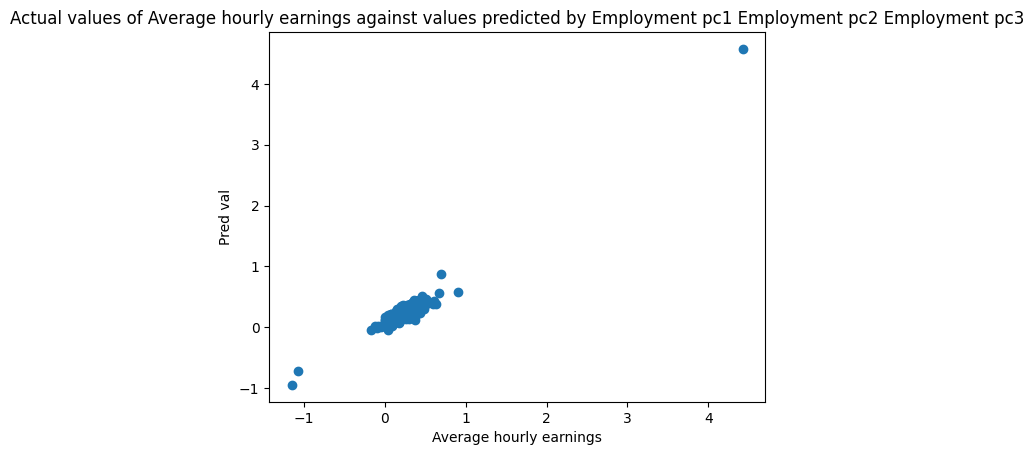

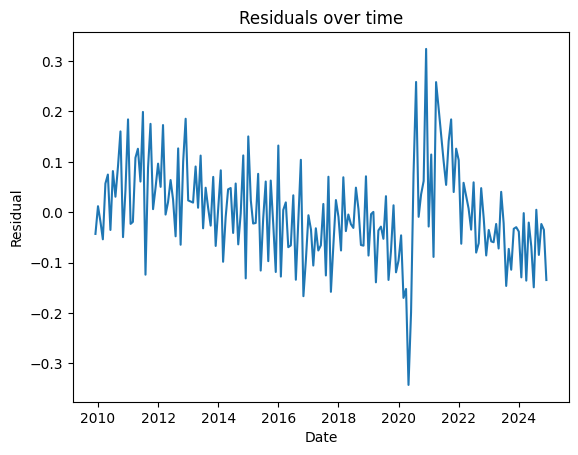





Target variable:  Initial claims 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': 139605.30550732973, 'Employment pc2': -131675.60744292586, 'Employment pc3': -131747.53617579085} 

R2:  0.7069535973071115 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

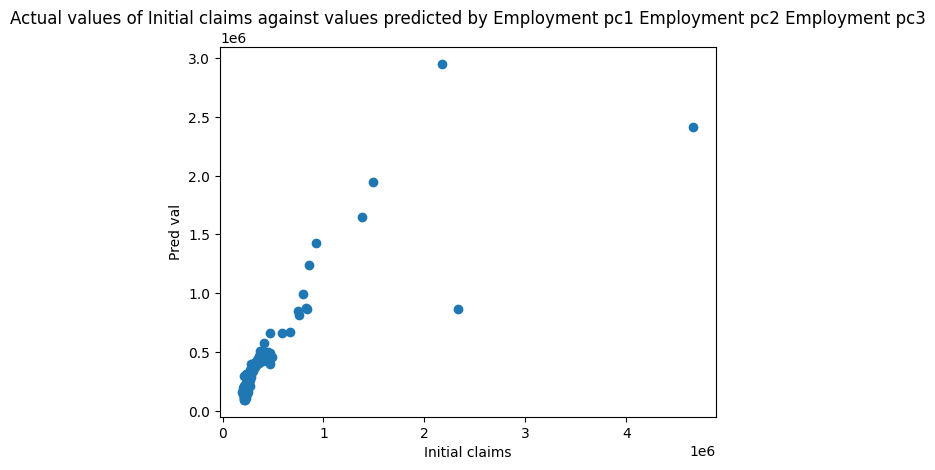

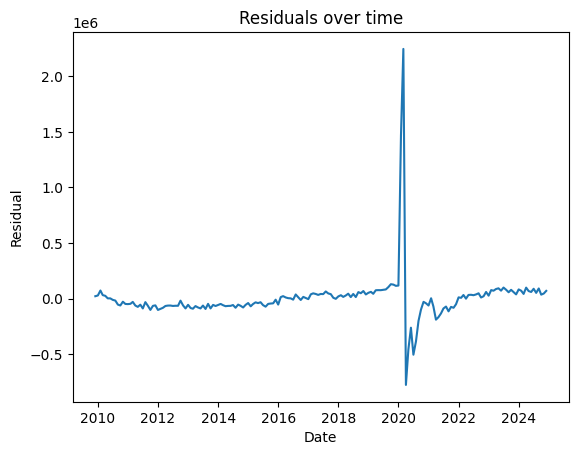





Target variable:  Continued claims 

Regressors:  Employment pc1 Employment pc2 Employment pc3 

Coefficients:  {'Employment pc1': 1103096.2821259138, 'Employment pc2': -808911.161136938, 'Employment pc3': -1095882.5189746586} 

R2:  0.9361172693436902 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

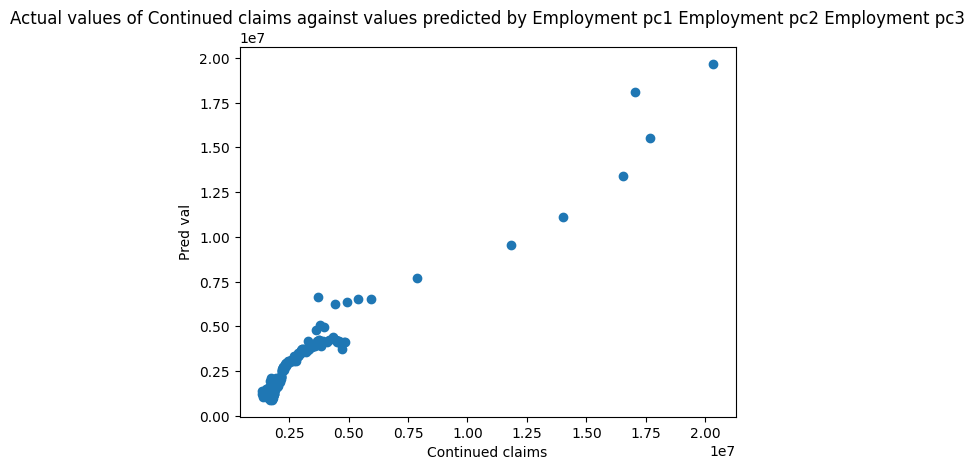

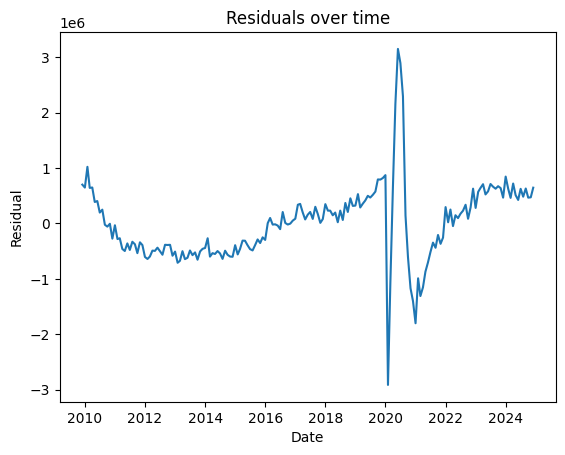





Target variable:  Fed funds rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.6076869337971386, 'Rates pc2': -0.5273251765766299} 

R2:  0.9465168030093517 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

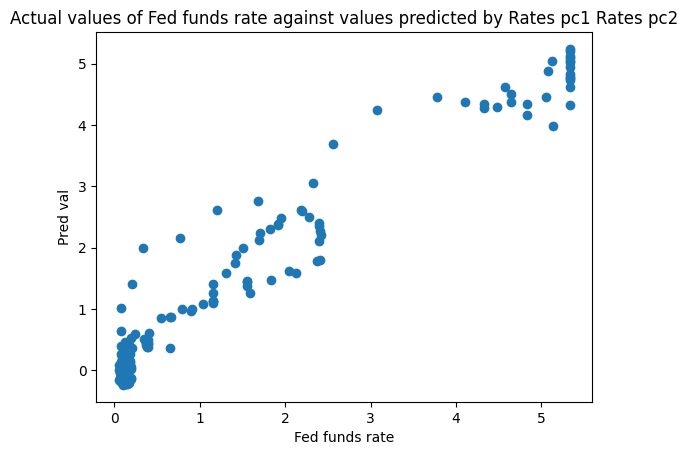

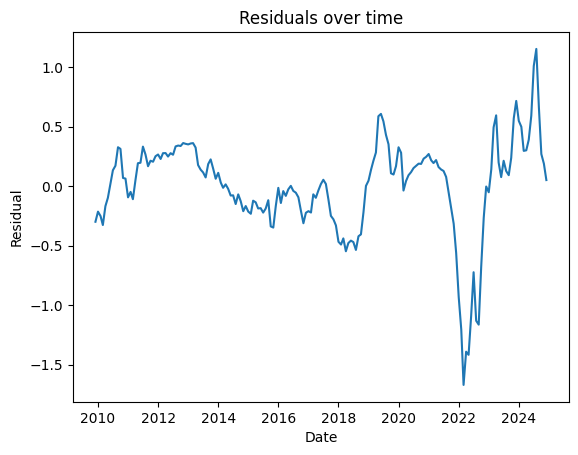





Target variable:  30y mortgage rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.4321777859440243, 'Rates pc2': 0.19474922124853575} 

R2:  0.9692505458089908 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

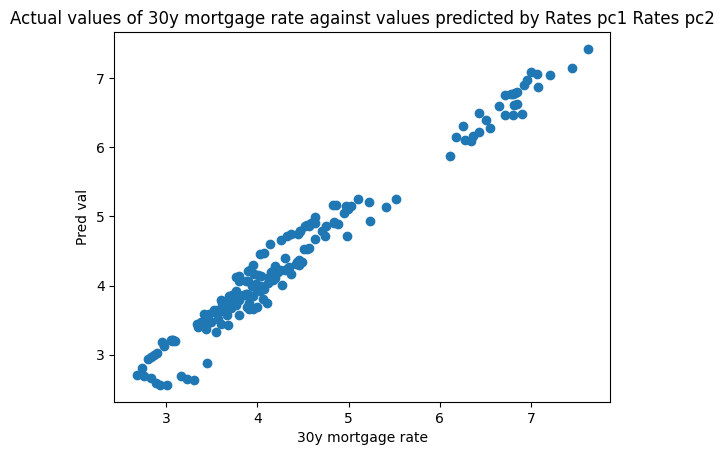

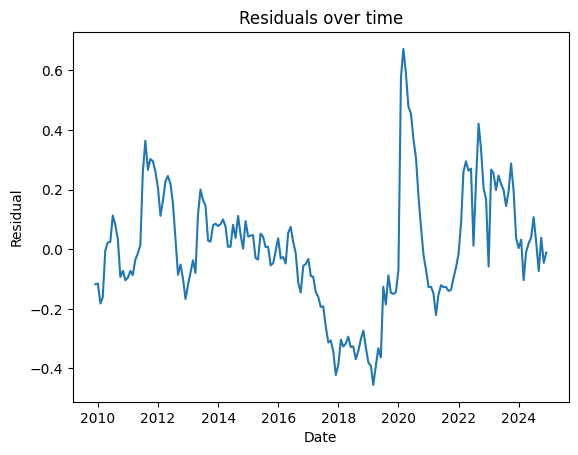





Target variable:  1y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.6083326327587759, 'Rates pc2': -0.539447096057109} 

R2:  0.9940187566031508 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

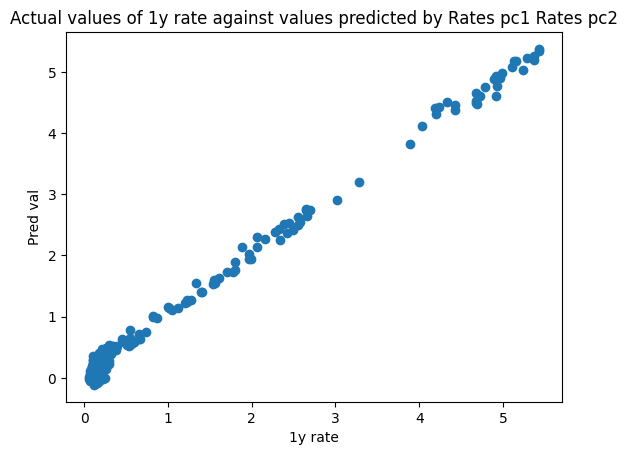

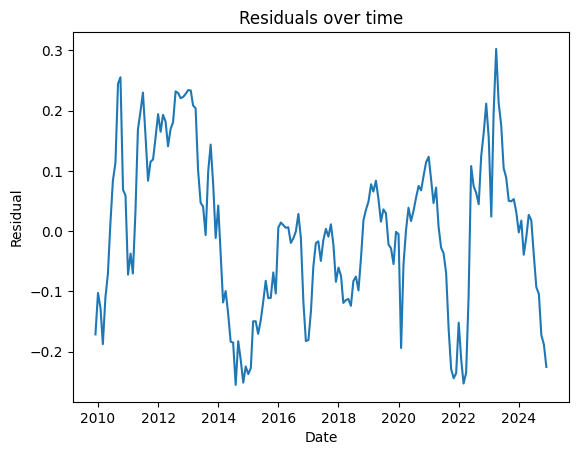





Target variable:  2y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.5462235426647356, 'Rates pc2': -0.40823731394279533} 

R2:  0.9956849475250658 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

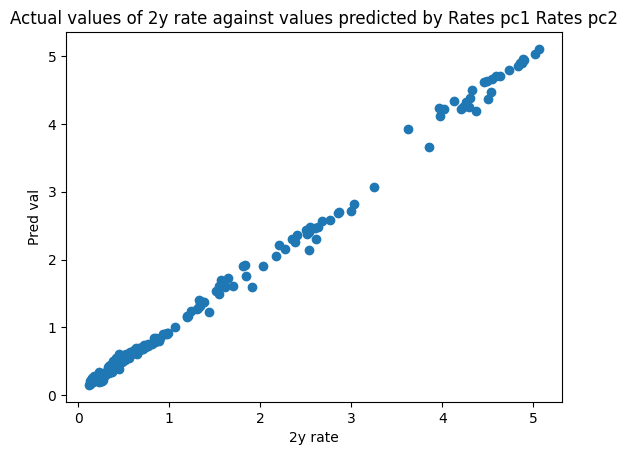

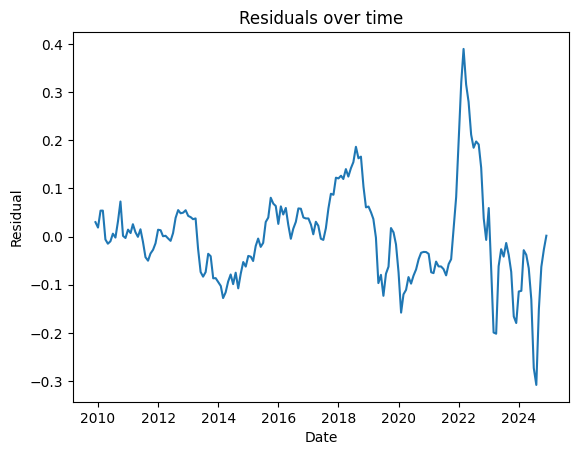





Target variable:  3y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.49991978975340606, 'Rates pc2': -0.2705384409637973} 

R2:  0.9866763085303858 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

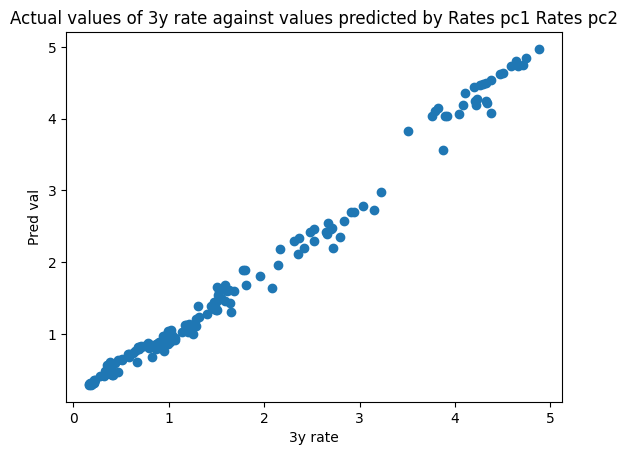

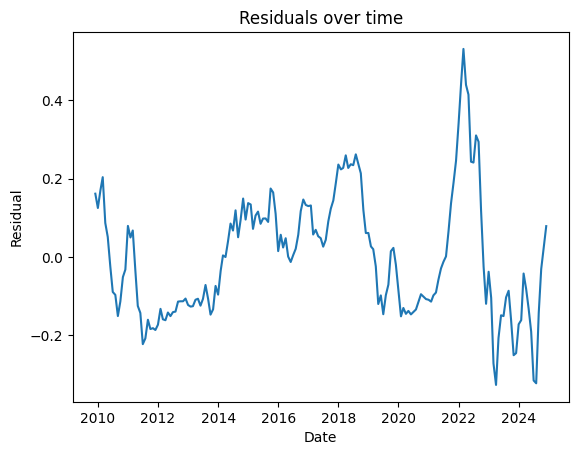





Target variable:  5y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.4266919282782914, 'Rates pc2': 0.006006131386910743} 

R2:  0.9732900417331958 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

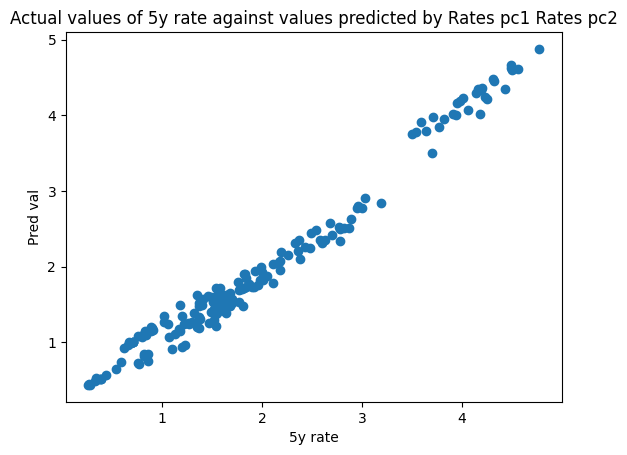

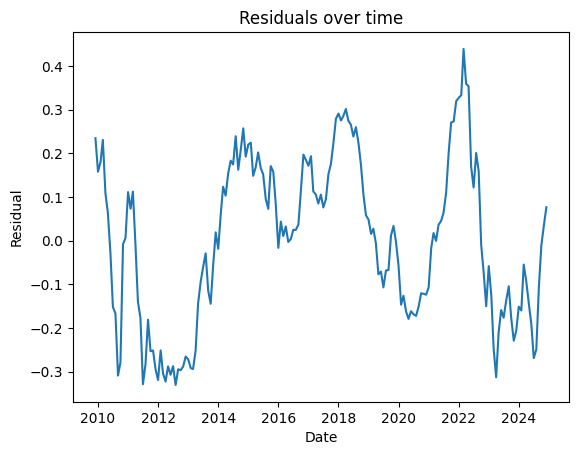





Target variable:  10y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.32635339439873634, 'Rates pc2': 0.3818377918731914} 

R2:  0.992488640162453 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

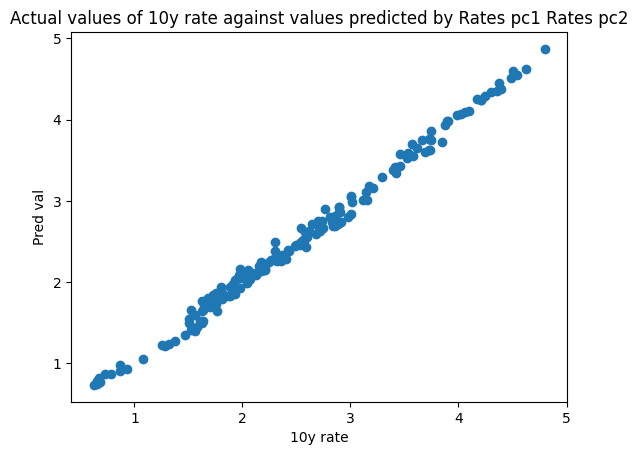

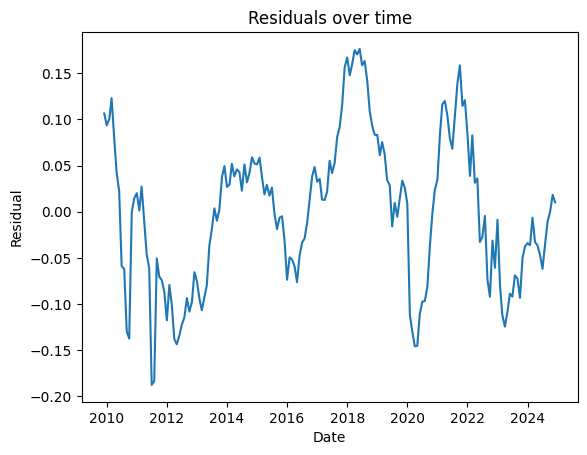





Target variable:  30y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.23228354564472575, 'Rates pc2': 0.5973089045318448} 

R2:  0.9881829030773784 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

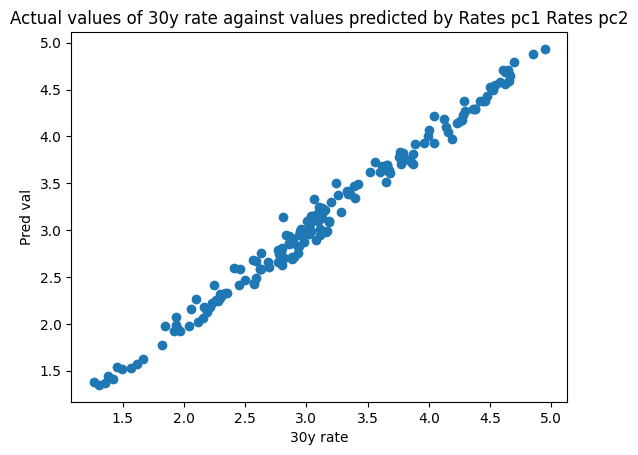

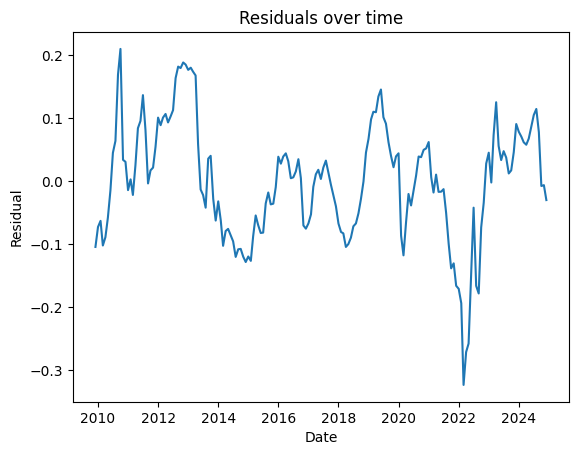

<Figure size 640x480 with 0 Axes>

In [50]:
for series in total_df_long_hist.columns:
  if "pc" in series:
    continue
  group = series_to_group[series]
  regressors = [col for col in total_df_long_hist.columns if "pc" in col and group in col]
  print("\n\n\n")
  calc_and_show_regression(total_df_long_hist[regressors], total_df_long_hist[series])

Look at PACF and spectral density of our 12 variables to get a sense of lag length. Apart from housing pc2, seems like first 2-3 lags are most significant

['Employment pc1', 'Employment pc2', 'Employment pc3', 'Prices pc1', 'Prices pc2', 'Housing pc1', 'Housing pc2', 'Rates pc1', 'Rates pc2']


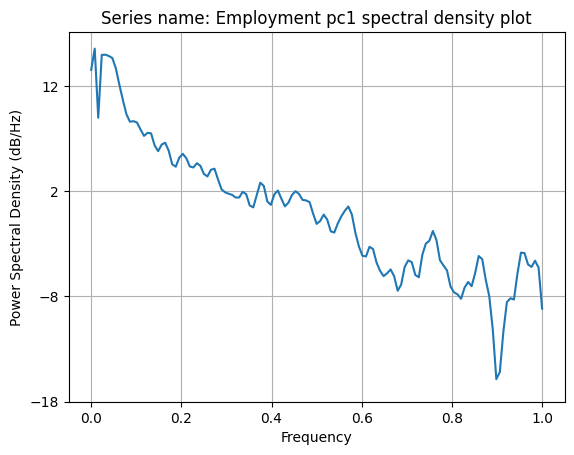

<Figure size 640x480 with 0 Axes>

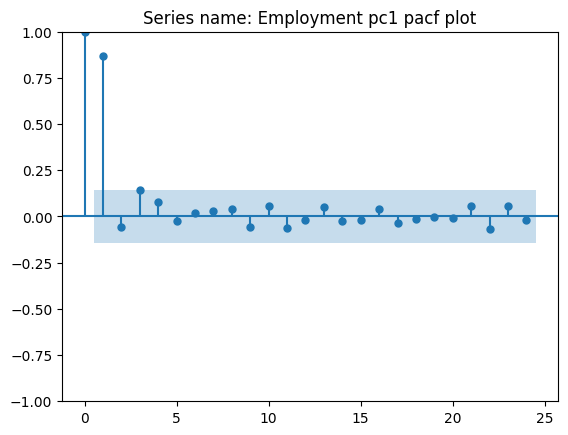

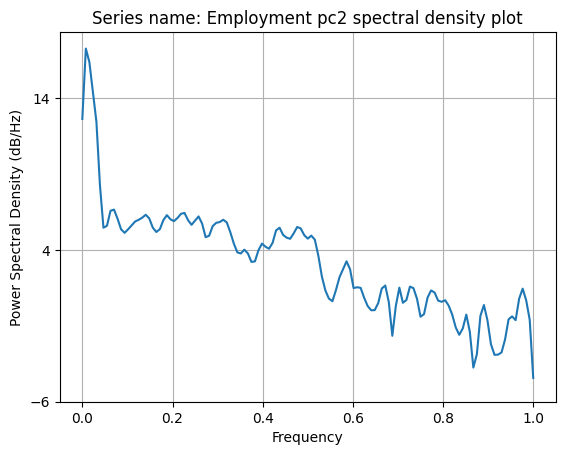

<Figure size 640x480 with 0 Axes>

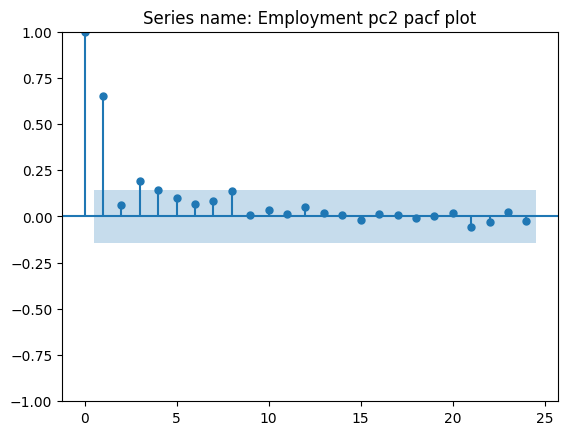

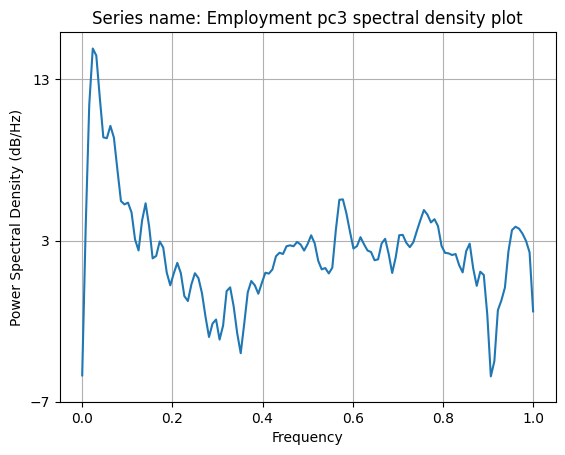

<Figure size 640x480 with 0 Axes>

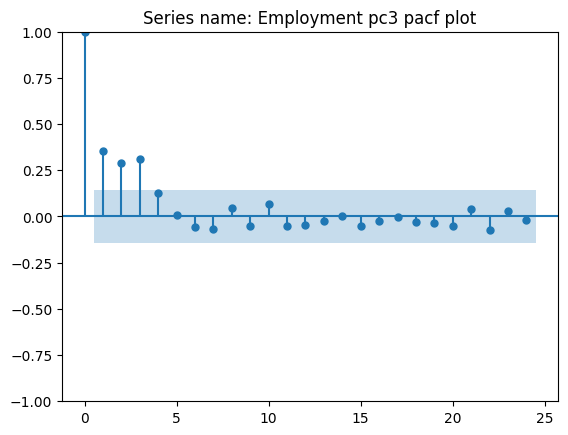

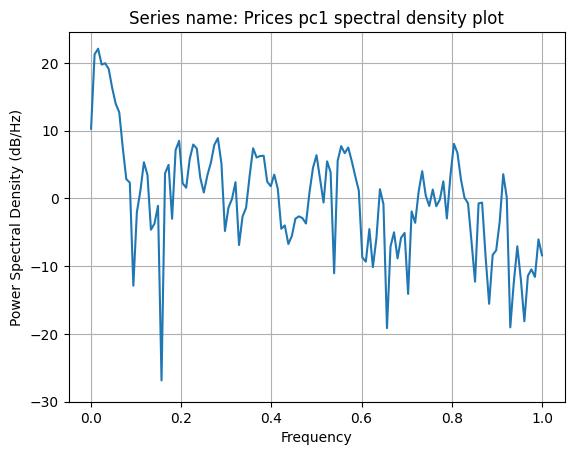

<Figure size 640x480 with 0 Axes>

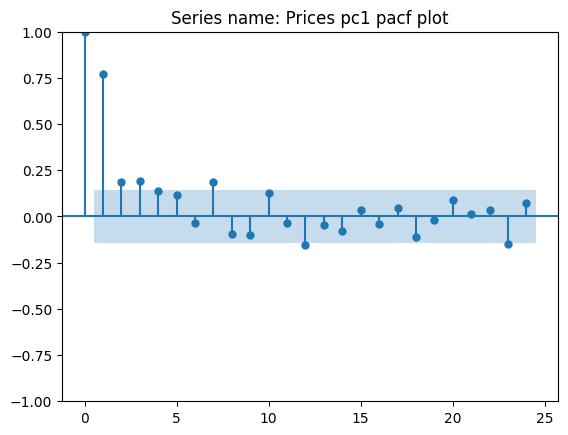

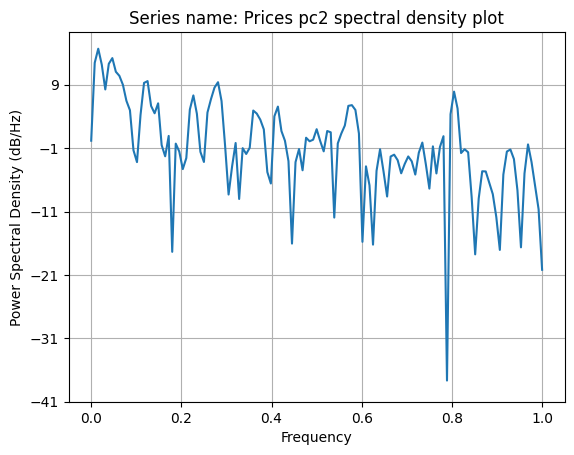

<Figure size 640x480 with 0 Axes>

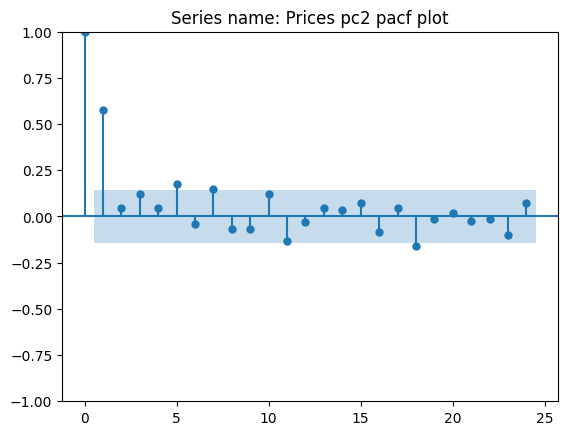

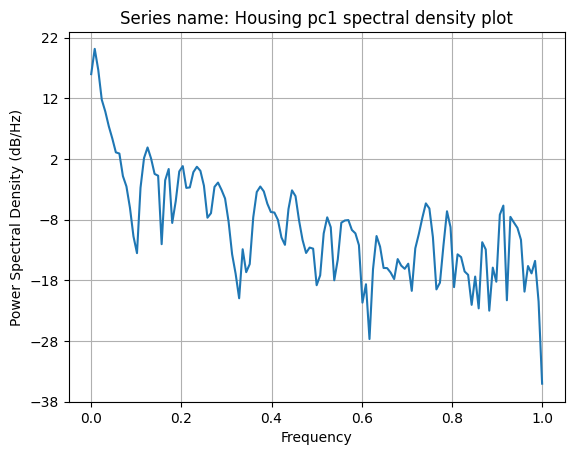

<Figure size 640x480 with 0 Axes>

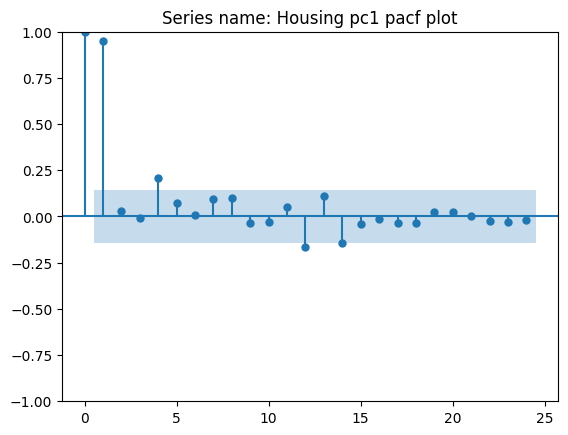

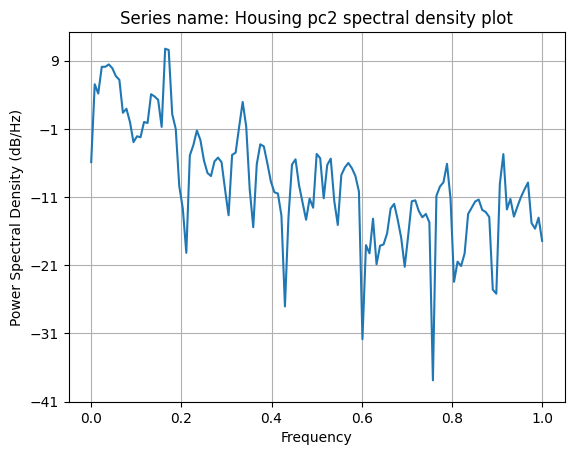

<Figure size 640x480 with 0 Axes>

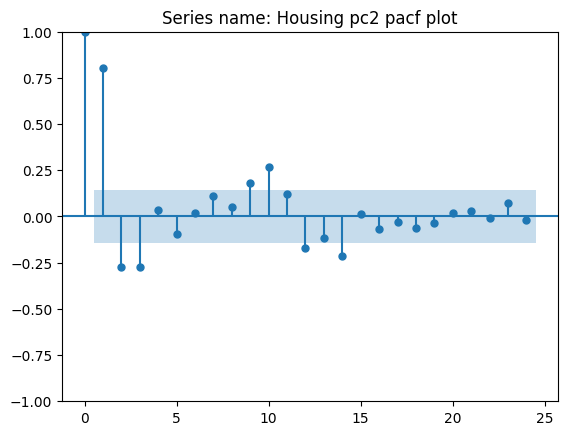

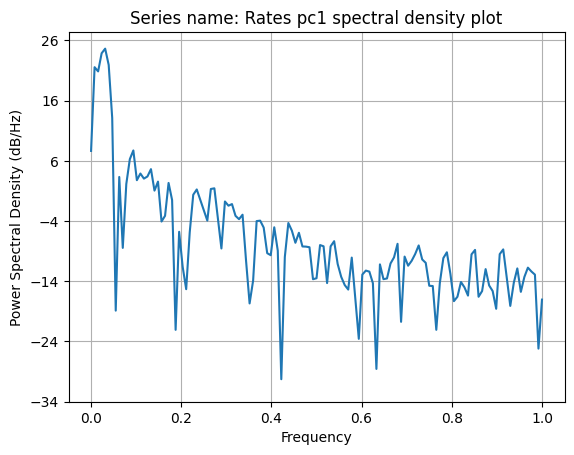

<Figure size 640x480 with 0 Axes>

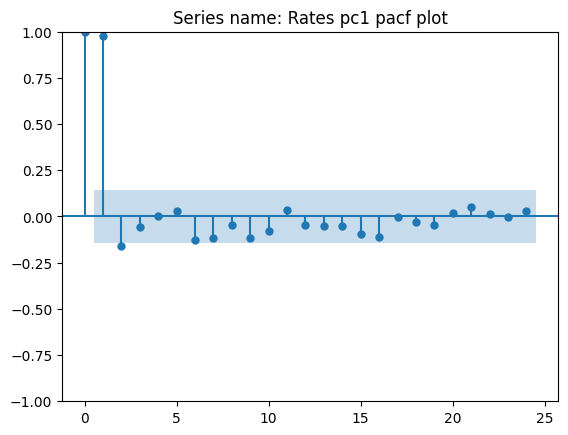

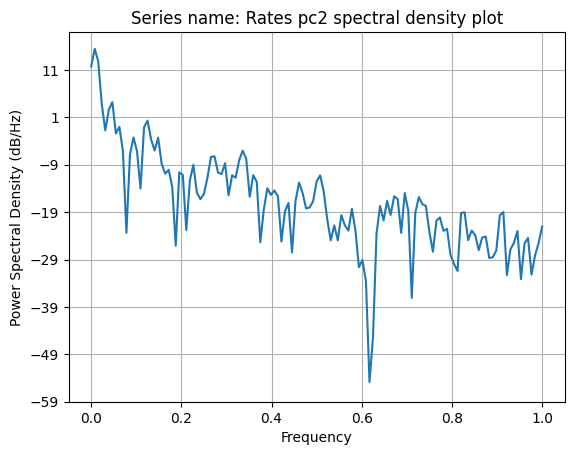

<Figure size 640x480 with 0 Axes>

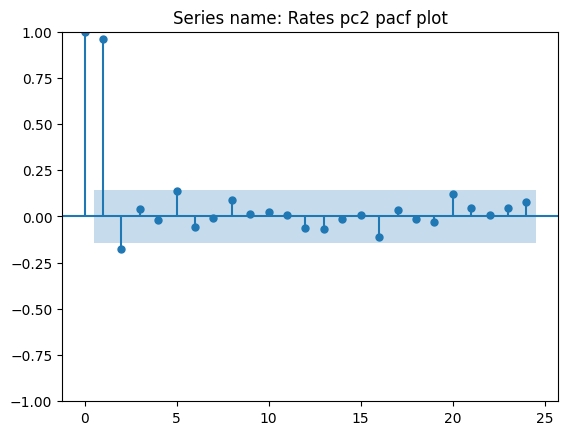

<Figure size 640x480 with 0 Axes>

In [13]:
#now lets try to fit a vecm model on the pcs to make predictions
#look at pacf plots and spectral densities to get a sense of lag length

retained_cols = [series for series in total_df_long_hist.columns if "pc" in series]
print(retained_cols)
pc_df = total_df_long_hist[retained_cols]
for series in pc_df.columns:
  plt.psd(pc_df[series])
  plt.title("Series name: "+ series+ " spectral density plot")
  plt.show()
  plt.clf()
  plot_pacf(pc_df[series], lags=24)
  plt.title("Series name: "+ series+ " pacf plot")
  plt.show()
  plt.clf()


Select lags with information criteria

In [30]:
#apart from housing PC2, PACF profiles decay quickly after first 2-3 lags
lag_order = select_order(data=pc_df, maxlags=7, deterministic="coci", seasons=0)
lag_order.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

<class 'statsmodels.iolib.table.SimpleTable'>

Determine number of cointegrating relationships using Johansen test with two lags and constant deterministic terms. We find seven relationships among the twelve variables

In [32]:
#determine # of cointegrating relationships
rank_test = select_coint_rank(pc_df, det_order=0, k_ar_diff=lag_order.aic, method="trace", signif=0.05)
rank_test.summary()
print(rank_test.summary())
print(rank_test.rank)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   9          543.6          197.4
  1   9          300.4          159.5
  2   9          216.8          125.6
  3   9          142.8          95.75
  4   9          76.96          69.82
  5   9          49.83          47.85
  6   9          24.01          29.80
-------------------------------------
6


Fit vecm with two lags, six cointegrating relationships, and constant term inside the cointegration parenthesis

In [33]:
#now we have enough info to fit the VECM model
model = VECM(pc_df, deterministic="ci", seasons=0, k_ar_diff=lag_order.aic, coint_rank=rank_test.rank)
vecm_model = model.fit()
vecm_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation Employment pc1
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.Employment pc1     0.4829      0.070      6.934      0.000       0.346       0.619
L1.Employment pc2    -0.6100      0.056    -10.921      0.000      -0.720      -0.501
L1.Employment pc3    -0.7767      0.051    -15.266      0.000      -0.876      -0.677
L1.Prices pc1        -0.0319      0.031     -1.044      0.297      -0.092       0.028
L1.Prices pc2         0.0254      0.033      0.764      0.445      -0.040       0.091
L1.Housing pc1       -0.0620      0.071     -0.874      0.382      -0.201       0.077
L1.Housing pc2       -0.0160      0.048     -0.334      0.739      -0.110       0.078
L1.Rates pc1         -0.4387      0.102     -4.293      0.000      -0.639      -0.238
L1.Rates pc2          0.6960      0.165      4.213      0.000       0.372       1.020
L2.Employment pc1    -0.3736      0.108     -3.470      0.001      -0.585      -0.163
L2.Employment pc2    -0.0772      0.069     -1.115      0.265      -0.213       0.059
L2.Employment pc3     0.0919      0.076      1.212      0.226      -0.057       0.241
L2.Prices pc1        -0.0273      0.029     -0.955      0.340      -0.083       0.029
L2.Prices pc2         0.0269      0.030      0.882      0.378      -0.033       0.087
L2.Housing pc1        0.0930      0.066      1.405      0.160      -0.037       0.223
L2.Housing pc2        0.0117      0.047      0.247      0.805      -0.081       0.104
L2.Rates pc1         -0.0102      0.107     -0.095      0.924      -0.220       0.200
L2.Rates pc2         -0.1422      0.176     -0.809      0.419      -0.487       0.202
Det. terms outside the coint. relation & lagged endog. parameters for equation Employment pc2
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.Employment pc1    -1.3651      0.076    -17.951      0.000      -1.514      -1.216
L1.Employment pc2     0.2894      0.061      4.744      0.000       0.170       0.409
L1.Employment pc3     0.5377      0.056      9.680      0.000       0.429       0.647
L1.Prices pc1         0.0271      0.033      0.813      0.416      -0.038       0.092
L1.Prices pc2        -0.0357      0.036     -0.983      0.325      -0.107       0.035
L1.Housing pc1        0.2640      0.077      3.408      0.001       0.112       0.416
L1.Housing pc2       -0.0111      0.052     -0.212      0.832      -0.114       0.092
L1.Rates pc1          0.0077      0.112      0.069      0.945      -0.211       0.226
L1.Rates pc2          0.1321      0.180      0.732      0.464      -0.221       0.486
L2.Employment pc1    -0.4616      0.118     -3.927      0.000      -0.692      -0.231
L2.Employment pc2     0.0209      0.076      0.277      0.782      -0.127       0.169
L2.Employment pc3     0.1108      0.083      1.337      0.181      -0.052       0.273
L2.Prices pc1        -0.0027      0.031     -0.087      0.931      -0.064       0.058
L2.Prices pc2        -0.0089      0.033     -0.267      0.789      -0.074       0.056
L2.Housing pc1        0.0127      0.072      0.175      0.861      -0.129       0.154
L2.Housing pc2       -0.1164      0.051     -2.261      0.024      -0.217      -0.015
L2.Rates pc1          0.2555      0.117      2.186      0.029       0.026       0.485
L2.Rates pc2         -0.2527      0.192     -1.317      0.188      -0.629       0.123
Det. terms outside the coint. relation & lagged endog. parameters for equation Employment pc3
==========================================================

Predict the PC factors two years out (24 steps). Then, call inverses of the PCA transform and scaler transform to recover estimated values of the 28 variables in our original space. The PCA loses some variance, so the inversion isn't one to one.

In [34]:
#Make predictions out to 2 years

pred_vals = vecm_model.predict(steps = 24)
pred_indices = [pc_df.index[-1].date()+relativedelta(months=k+1) for k in range(24)]
pred_df = pd.DataFrame(index = pred_indices, columns = pc_df.columns, data = pred_vals)
pred_df[pca_component_dict["Rates"].columns] = scaler_dict["Rates"].inverse_transform(pca_object_dict["Rates"].inverse_transform(pred_df[[series for series in pred_df.columns if "Rates" in series]]))
pred_df[pca_component_dict["Housing"].columns] = scaler_dict["Housing"].inverse_transform(pca_object_dict["Housing"].inverse_transform(pred_df[[series for series in pred_df.columns if "Housing" in series]]))
pred_df[pca_component_dict["Prices"].columns] = scaler_dict["Prices"].inverse_transform(pca_object_dict["Prices"].inverse_transform(pred_df[[series for series in pred_df.columns if "Prices" in series]]))
pred_df[pca_component_dict["Employment"].columns] = scaler_dict["Employment"].inverse_transform(pca_object_dict["Employment"].inverse_transform(pred_df[[series for series in pred_df.columns if "Employment" in series]]))

extended_df = pd.concat([total_df_long_hist, pred_df], axis=0)


Plot our forecasts next to the actual values for the last two years. Notice that for some variables, there is discontinuity at 01/01/2025 as we switch from actual values to predicted values. It requires some proof, but these variables are likely sacrificed by the PCA, so our predictions of the PCs tell us very little about these variables.

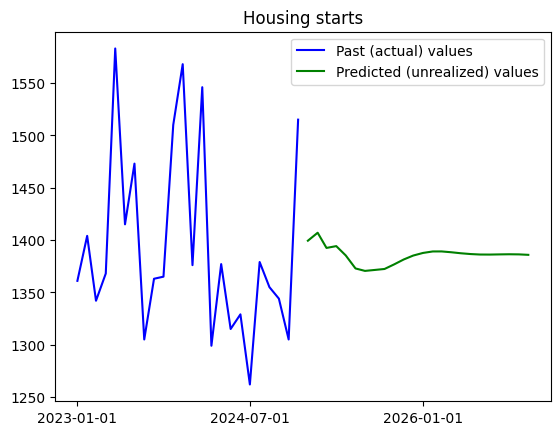

<Figure size 640x480 with 0 Axes>

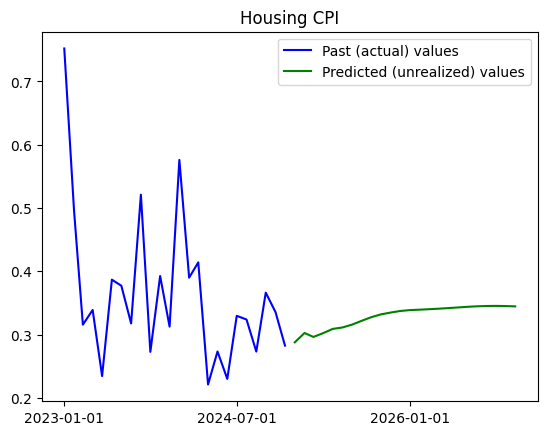

<Figure size 640x480 with 0 Axes>

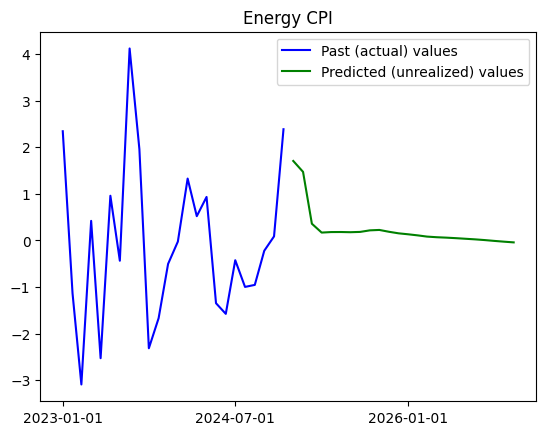

<Figure size 640x480 with 0 Axes>

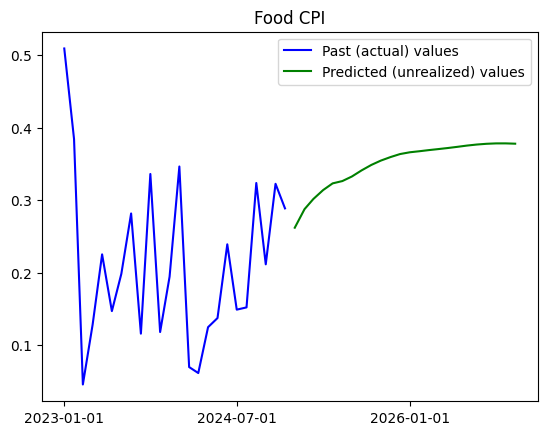

<Figure size 640x480 with 0 Axes>

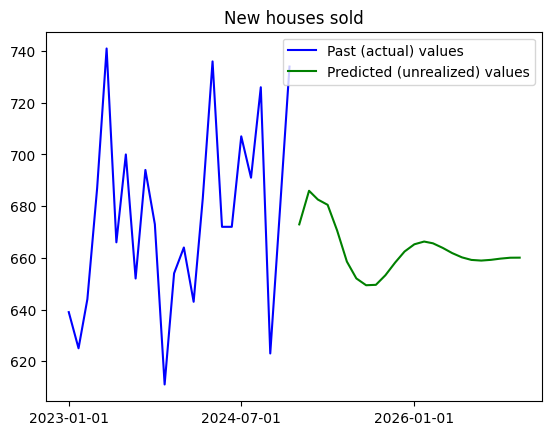

<Figure size 640x480 with 0 Axes>

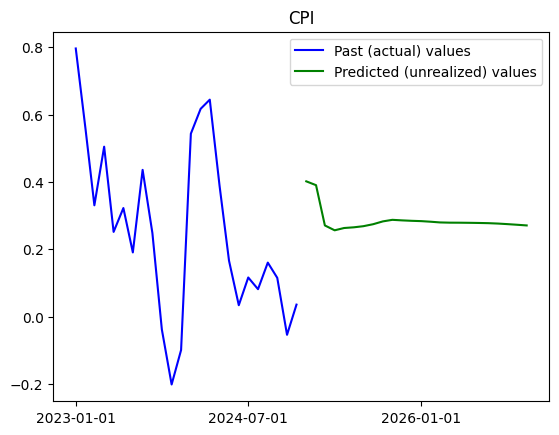

<Figure size 640x480 with 0 Axes>

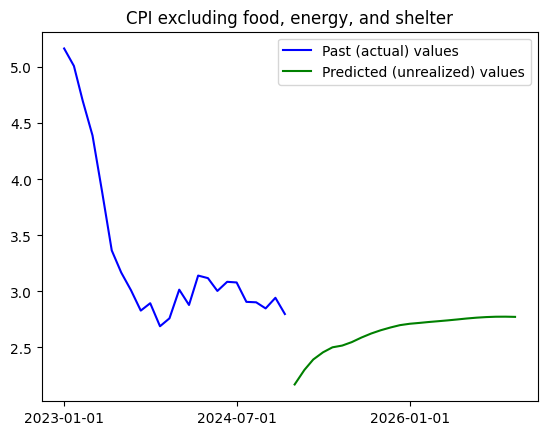

<Figure size 640x480 with 0 Axes>

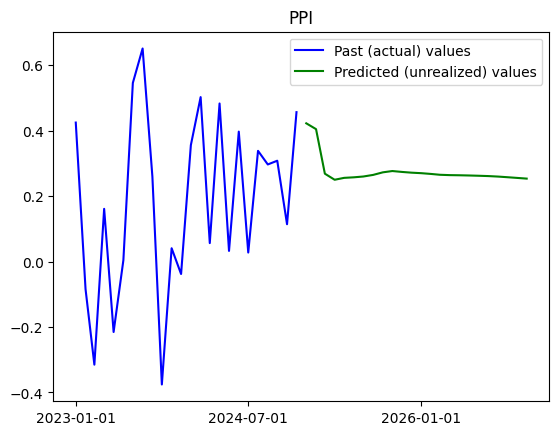

<Figure size 640x480 with 0 Axes>

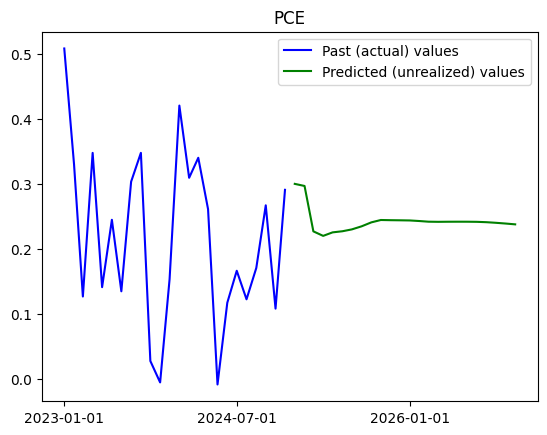

<Figure size 640x480 with 0 Axes>

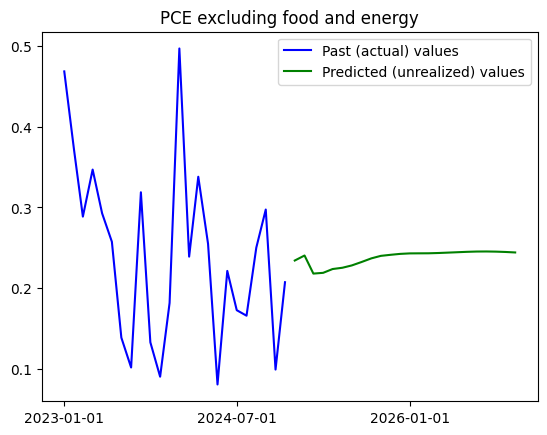

<Figure size 640x480 with 0 Axes>

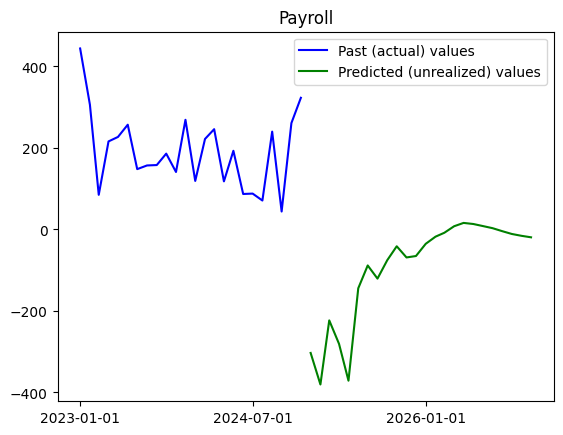

<Figure size 640x480 with 0 Axes>

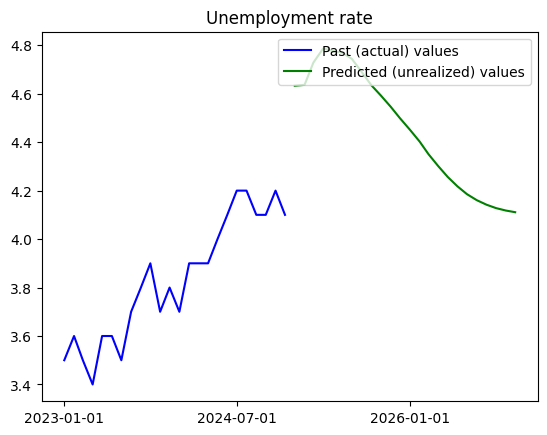

<Figure size 640x480 with 0 Axes>

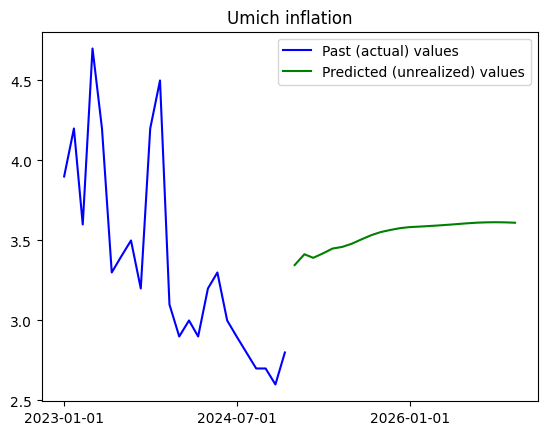

<Figure size 640x480 with 0 Axes>

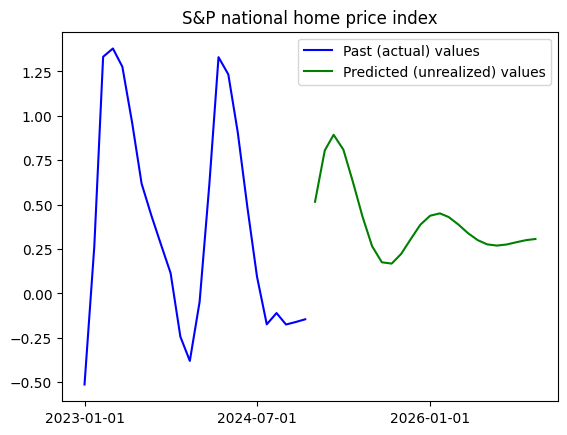

<Figure size 640x480 with 0 Axes>

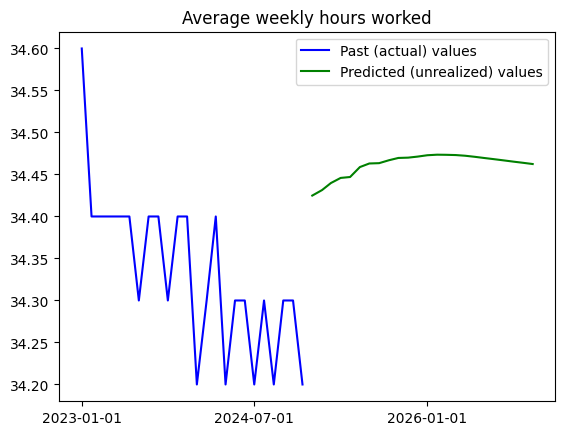

<Figure size 640x480 with 0 Axes>

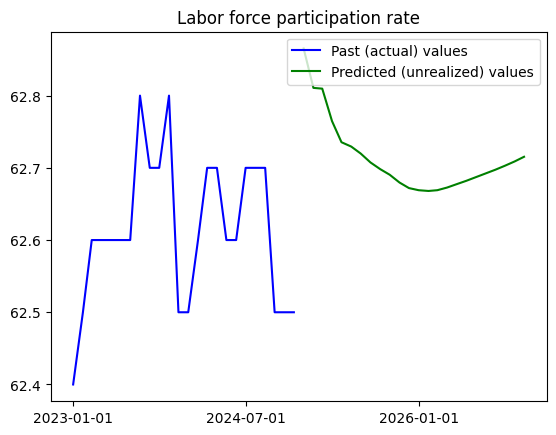

<Figure size 640x480 with 0 Axes>

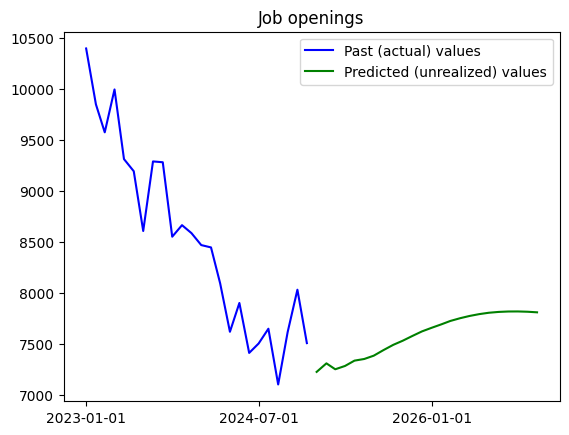

<Figure size 640x480 with 0 Axes>

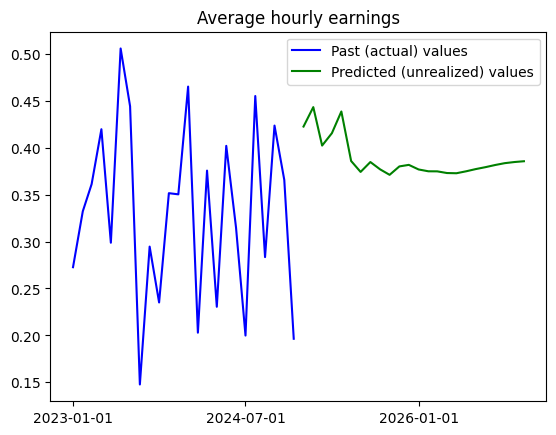

<Figure size 640x480 with 0 Axes>

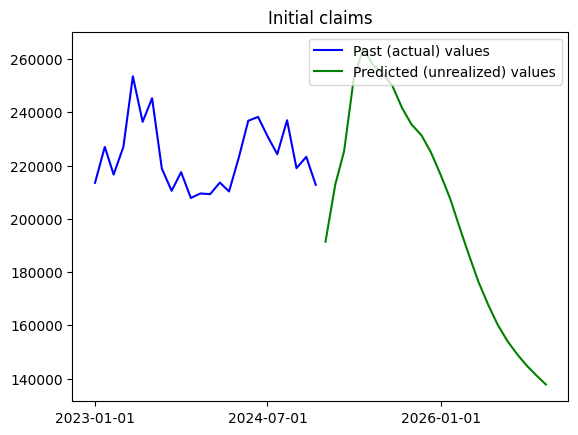

<Figure size 640x480 with 0 Axes>

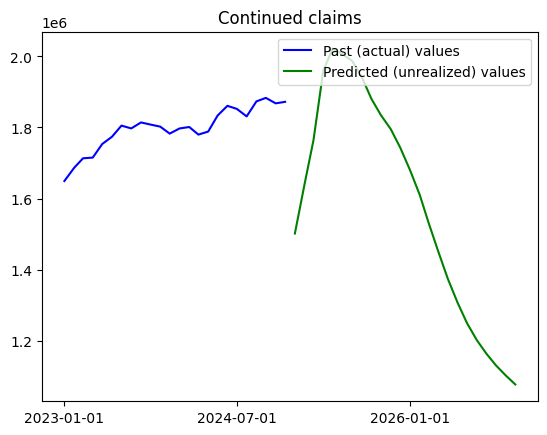

<Figure size 640x480 with 0 Axes>

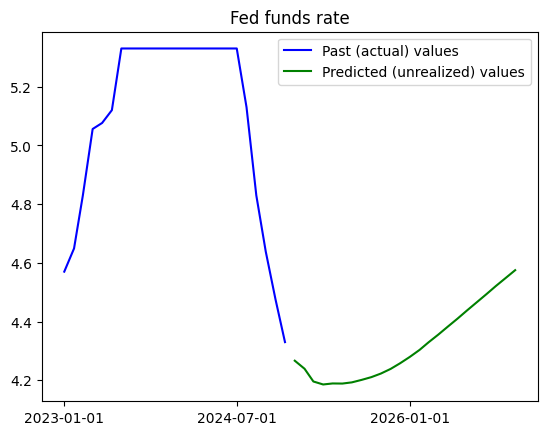

<Figure size 640x480 with 0 Axes>

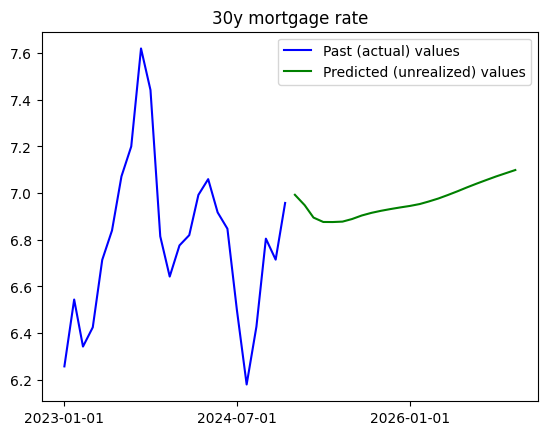

<Figure size 640x480 with 0 Axes>

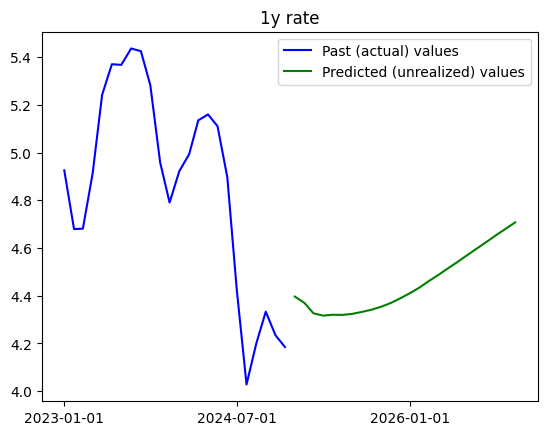

<Figure size 640x480 with 0 Axes>

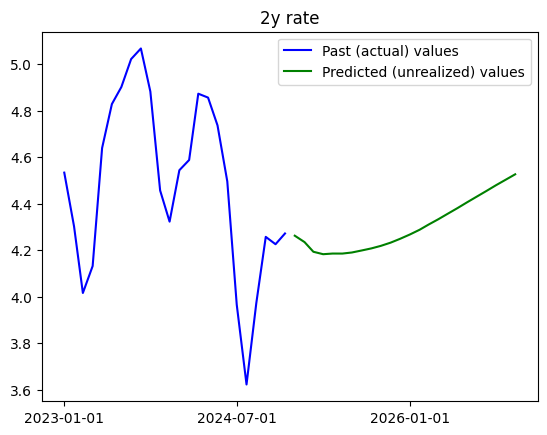

<Figure size 640x480 with 0 Axes>

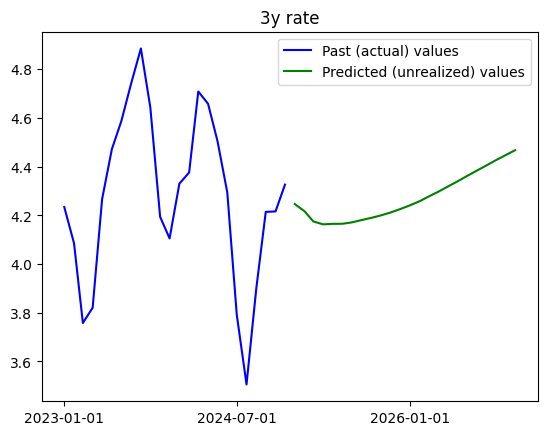

<Figure size 640x480 with 0 Axes>

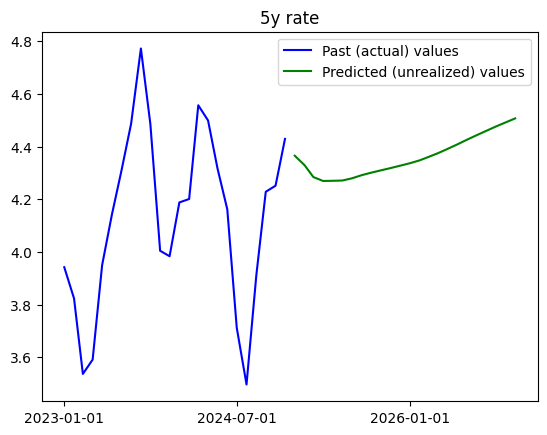

<Figure size 640x480 with 0 Axes>

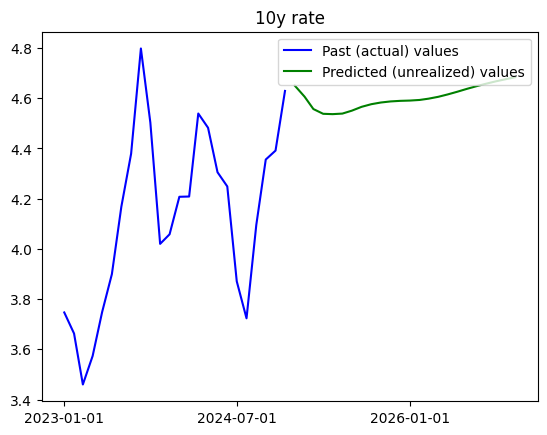

<Figure size 640x480 with 0 Axes>

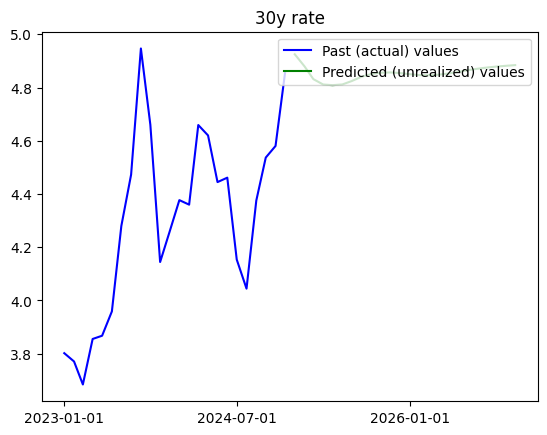

<Figure size 640x480 with 0 Axes>

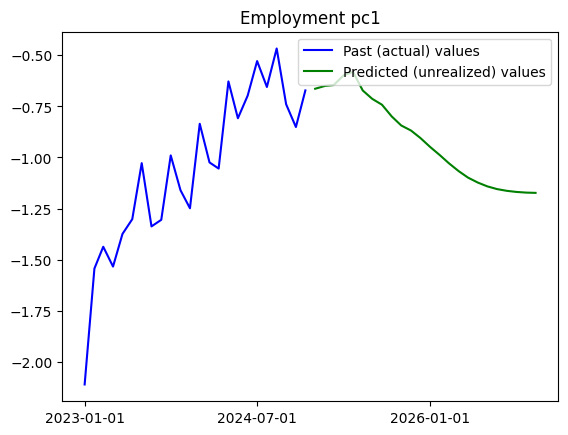

<Figure size 640x480 with 0 Axes>

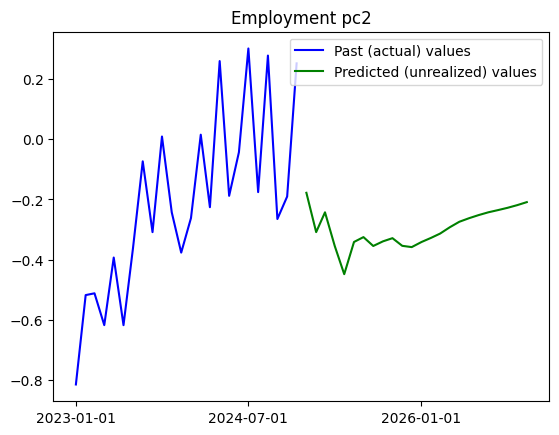

<Figure size 640x480 with 0 Axes>

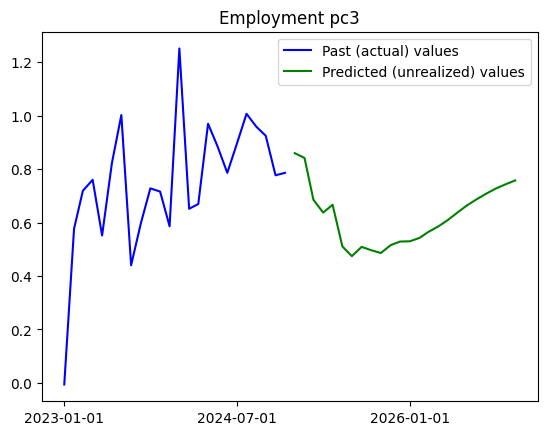

<Figure size 640x480 with 0 Axes>

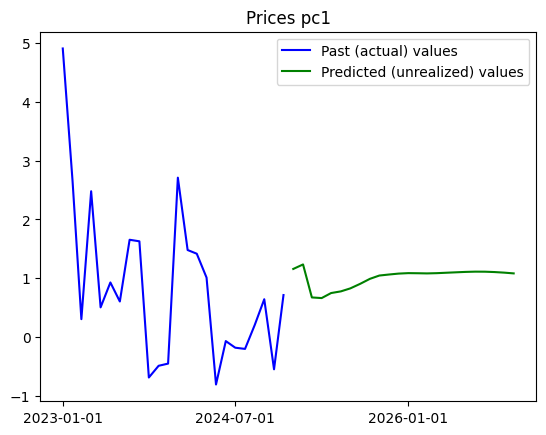

<Figure size 640x480 with 0 Axes>

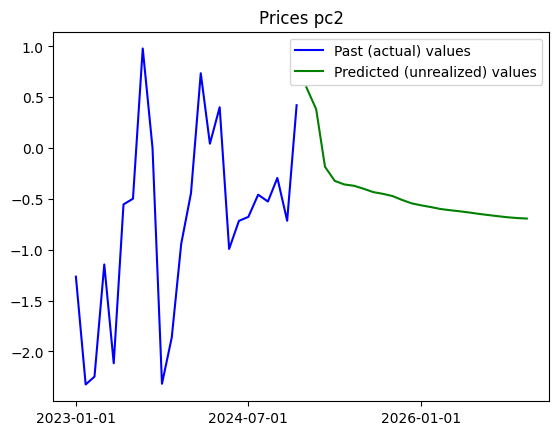

<Figure size 640x480 with 0 Axes>

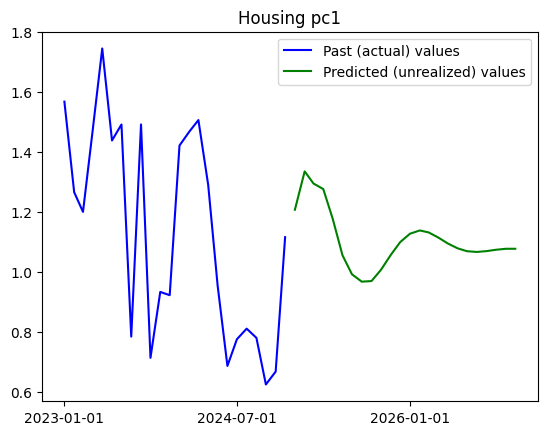

<Figure size 640x480 with 0 Axes>

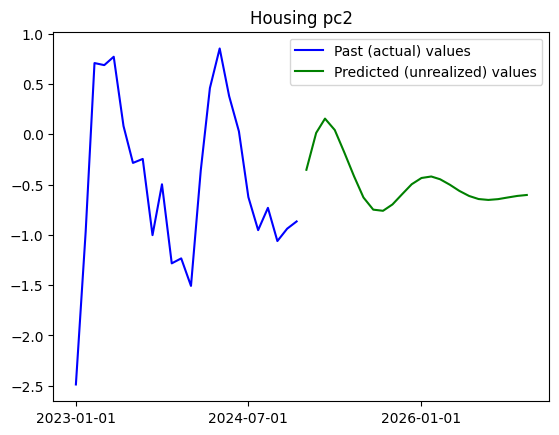

<Figure size 640x480 with 0 Axes>

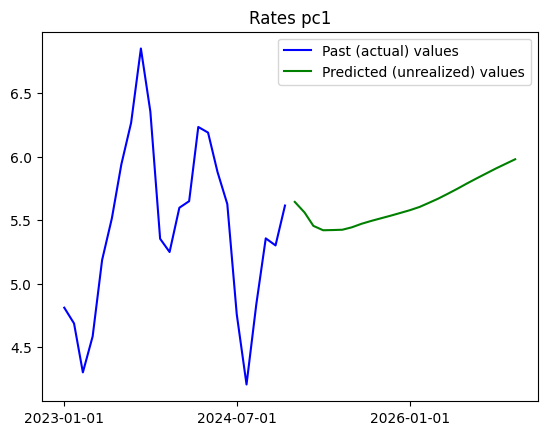

<Figure size 640x480 with 0 Axes>

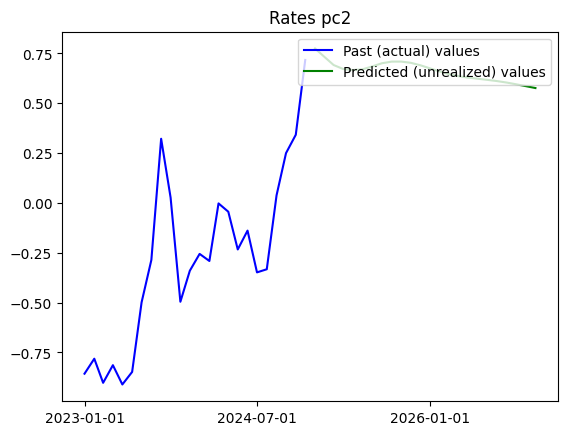

<Figure size 640x480 with 0 Axes>

In [35]:
#plot last two years of real data next to our forecasts two years out
for series in extended_df.columns:
  fig, ax = plt.subplots()
  l1 = ax.plot(extended_df[series].loc[filter(lambda x: 2023<=x.year<=2024, extended_df.index)], color = "blue")[0]
  l2 = ax.plot(extended_df[series].loc[filter(lambda x: 2025<=x.year<=2026, extended_df.index)], color = "green")[0]
  ax.set_title(series)
  ax.legend((l1, l2), ("Past (actual) values", "Predicted (unrealized) values"), loc="upper right")
  ax.set_xticks(ax.get_xticks()[::len(ax.get_xticks())//3])
  plt.show()
  plt.clf()

Prediction summary: higher rates, stable curve, Fed hikes, sticky inflation, brief negative shock to the labor market followed by normalization. Results on employment data are questionable compared to smoother predictions for housing/prices/rates. The poor performance on employment data makes sense in light of the sparser PCA for employment data, as well as the lack of mean reversion of most employment series toward values predicted by the factors (see the regressions of individual variables against factors above).


Why we should be skeptical: core predictions are contrary to popular wisdom (lower rates, Fed easing, steeper curve, higher unemployment). The number of data points (~200) is slim relative to the number of variables (9 latent variables). More importantly, distinct historical regimes (such as the 2020-2022 COVID period) have fewer than 30 data points with 9 latent variables.

In general, the model points the PCs toward a recent mean. Interestingly, this gravitation toward recent means implies interest rate hikes (undoing the recent cuts) without acceleration in CPI prints. In the real world, we know that a return to monetary tightening requires some economic catalyst that would be reflected in upward price pressures. To predict a Fed reversal with normalizing indicators is absurd. Moreover, the absence of a flattening yield curve in the predictions is out of touch with historical evidence that hikes in Fed Funds cause significant bear flattening in the yield curve.